In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) # uncomment to see all the rows in a dataframe

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

from astropy.io import fits
from astropy.coordinates import FK5, SkyCoord
import astropy.units as u

from XRBID.DataFrameMod import (Find, FindUnique)
from XRBID.CMDs import FitSED
from XRBID.WriteScript import WriteReg

import os, sys
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
from helpers.analysis import remove_unnamed, XrayBinary
from helpers.analysis import (calculate_distance, calculate_velocity)

import seaborn as sns

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"


# Adapting `RunPhots` for JWST

In [3]:
from XRBID.AutoPhots import DaoFindObjects
    

data = fits.getdata(f200w)
data = data[3200:3400, 3200:3400]
objects = DaoFindObjects(data, fwhm=0.14, pixtoarcs=0.031, vmax=10, plot=True)

TypeError: DaoFindObjects() got an unexpected keyword argument 'vmax'

In [ ]:
from photutils.aperture import aperture_photometry, CircularAperture
from photutils.utils import calc_total_error

def perform_photometry(data_sub, data, hdu, apertures, instrument, filter, type, gal, suffix="", calc_error=True, savefile=True):
    '''
    A helper function to calculate the aperture photometry.
	
	PARAMETERS
	----------
	data_sub  [nd.array] : Background subtracted data
	apertures      [int] : the aperture size passed for performing the aperture photometry
	type           [str] : the type of photometry being performed -- full, extended or source
	savefile      [bool] (True): Save the outputs from aperture photometry
	
    RETURNS
	-------
	photometry   [array] : The photometric information of the sources. 
	
	OTHER PRODUCTS
	-------------------
    Region file for all daofind sources in the field in fk5 coordinates.
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_full[SUFFIX].ecsv: 
    Datafile containing the full 1-30 pixel aperture photometry of all sources in the field
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_sources[SUFFIX].ecsv: 
    Datafile containing the 3 pixel aperture photometry of all sources in the field
        photometry_[GALAXY]_[FILTER]_[INSTRUMENT]_extended[SUFFIX].ecsv: 
    Datafile containing the extended pixel aperture photometry of all sources in the field
    '''
    hst_instrument = ['acs', 'wfc3']
    if calc_error:  # If error needs to be calculated (this is mainly for extended and source photometry)
        # If hst instrument
        if instrument in hst_instrument: 
            photometry = aperture_photometry(data_sub, apertures, error=calc_total_error(data, \
                            data-data_sub, effective_gain=hdu[0].header["EXPTIME"]))
            
        else: # If jwst instrument
                photometry = aperture_photometry(data_sub, apertures, error=calc_total_error(data, \
                            data-data_sub, effective_gain=hdu[1].header["XPOSURE"]))

    else: # if you dont need to calculate error
            photometry = aperture_photometry(data_sub, apertures, method='center')

    if savefile:
        photometry.write("photometry_"+gal+"_"+filter.lower()+"_"+instrument.lower()+"_"+type+suffix+".ecsv", overwrite=True)
        print("photometry_"+gal+"_"+filter.lower()+"_"+instrument.lower()+"_"+type+suffix+".ecsv", "saved")
         
    return photometry

# Create Apertures
def create_apertures(positions, rad_list=(1, 31)):
    ap_rads = [i for i in range(1,31)]
    apertures_full = [CircularAperture(positions, r=r) for r in ap_rads]
    apertures_source = CircularAperture(positions, r=3) # 3px aperture photometry used for sources by default
    apertures_extended = CircularAperture(positions, r=10) # aperture photometry for clusters (default is 10 pixels)
    return apertures_full, apertures_source, apertures_extended


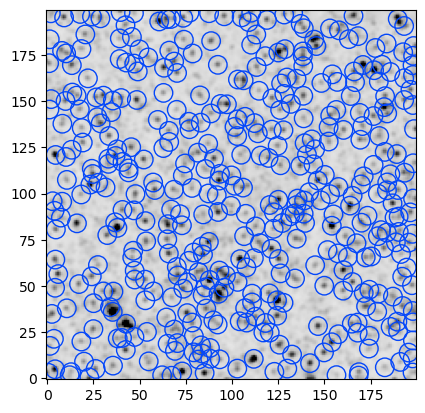

Background subtraction successful
Photometry...
photometry_M66_f200w_nircam_full.ecsv saved
photometry_M66_f200w_nircam_sources.ecsv saved
photometry_M66_f200w_nircam_extended.ecsv saved


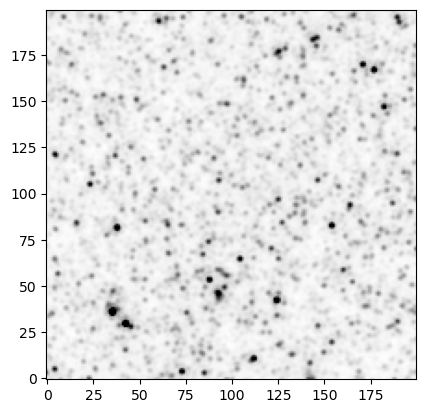

In [ ]:
from XRBID.AutoPhots import DaoFindObjects, SubtractBKG, perform_photometry
from photutils.aperture import CircularAperture

min_rad=3
extended_rad=10
instrument='nircam'
gal="M66"
hdu = fits.open(f200w)
data = fits.getdata(f200w)
data = data[3200:3400, 3200:3400]
filter='F200W'

# find objects
objects = DaoFindObjects(data, sigma=5, fwhm=0.14, threshold=3, pixtoarcs=0.031, savereg=False, plot=True, vmax=10)

# subtract background
data_sub = SubtractBKG(data)
print("Background subtraction successful")
plt.imshow(data_sub, cmap='gray_r', vmax=10, origin='lower')

# Aperture Corrections
positions = np.transpose((objects['xcentroid'], objects['ycentroid']))
# Create apertures
ap_rads = [i for i in range(1,31)]
apertures_full = [CircularAperture(positions, r=r) for r in ap_rads]
apertures_source = CircularAperture(positions, r=min_rad) # 3px aperture photometry used for sources by default
apertures_extended = CircularAperture(positions, r=extended_rad) # aperture photometry for clusters (default is 10 pixels)

print("Photometry...")
# Generate aperture photometry with the background-subtracted data
# perform_photometry(data_sub, hdu, apertures, instrument, filter, type, gal, suffix="", calc_error=True, savefile=True):
phot_full = perform_photometry(data_sub, data, hdu, apertures_full, instrument=instrument, filter=filter, type='full', gal=gal, calc_error=False)
phot_sources = perform_photometry(data_sub, data, hdu, apertures_source, instrument=instrument, filter=filter, type='sources', gal=gal, calc_error=True)
phot_extended = perform_photometry(data_sub, data, hdu, apertures_extended, instrument=instrument, filter=filter, type='extended', gal=gal, calc_error=True)


In [ ]:
def create_apertures(positions, rad_list, min_rad=3, extended_rad=10):
    ''' 
    A helper function to create apertures for doing the photometry.
    
    PARAMETERS
    ----------
    positions [nd.array] : Positions of the point sources detected through the DAOFind algorithm.
    rad_list  [list] : A list of aperture radii to be used for the photometry.
    min_rad [float] (3) : Minimum radius to be used.
    max_rad [float] (10) : Maximum radius to be used for extended sources
                          (in this case, clusters)
    '''
    apertures_full = [CircularAperture(positions, r=r) for r in rad_list]
    apertures_source = CircularAperture(positions, r=min_rad) # 3px aperture photometry used for sources by default
    apertures_extended = CircularAperture(positions, r=extended_rad) # aperture photometry for clusters (default is 10 pixels)
    return apertures_full, apertures_source, apertures_extended

In [ ]:
%%time 
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])

hdu = fits.open(f200w)
RunPhots(hdu, gal='M66', fwhm_arcs=0.14, pixtoarcs=0.031, instrument='nircam', filter='F200W', zeropoint=zeropoint)

# Fixing `RunPhots` so it creates the correct region files for my use. 

Date: 21 May 2025
First, I am testing out the regions library and see if I can do anything with that. 

I am going to test the `regions` library to create a regions file for the sources detected by JWST NIRCam.

**IMPORTANT**
- A Region object can represent only one region, not an array of regions. See the workaround below

So, I could not do much with the regions library but I fixed the WriteReg bug in RunPhots. 

0.14


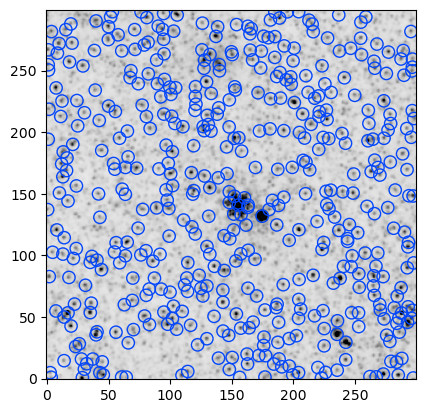

In [ ]:
# I am satisfied with this configuration.

data = fits.getdata(f200w)
data = data[3200:3500, 3000:3300]
pixtoarcs = 0.031 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.14
print(fwhm)
objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=True, vmax=10)

In [ ]:
# This works!!!
from regions import PixCoord, CirclePixelRegion
from regions import Regions

# Create a list of tuples of the coordinates of x and y positions
reg_list = []
for i in range(len(objects)):
    x = objects['xcentroid'][i]
    y = objects['ycentroid'][i]
    coordinate = (x, y)
    reg_list.append(coordinate)

# Create Pixel coordinates
regions = []
for x, y in reg_list:
    # print(f"x = {x} and y = {y}")
    # region = CirclePixelRegion(center=PixCoord(x, y), radius=3)
    regions.append(CirclePixelRegion(center=PixCoord(x, y), radius=3))

# Create Regions object
regs = Regions(regions)   
regs.write('test_region_img.reg', format='ds9')

# Create another fits file with the image above to test everything out
image_hdu = fits.PrimaryHDU(data=data)
hdul = fits.HDUList([image_hdu])
hdul.writeto("Test.fits")

474
Length of reg_list: 474
length of regions 474


In [ ]:
# Convert pixel coordinates to fk5 
from astropy.wcs import wcs

hdulist = fits.open(f200w)
wcs = wcs.WCS(hdulist[1].header, hdulist)
hdulist.close()
regions[0].to_sky(wcs)

sky_regs = []
for i in range(len(regions)):
    sky_regs.append(regions[i].to_sky(wcs))

In [ ]:
sky_regions = Regions(sky_regs)

1. astropy.io ascii
2. sublime find and replace

In [ ]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from regions import PixCoord
from regions import CircleSkyRegion, CirclePixelRegion

center_sky = SkyCoord(42, 43, unit='deg', frame='fk5')
region_sky = CircleSkyRegion(center=center_sky, radius=3 * u.deg)
# region_pix = CirclePixelRegion(center=PixCoord(x=42, y=43),
#                                radius=4.2)


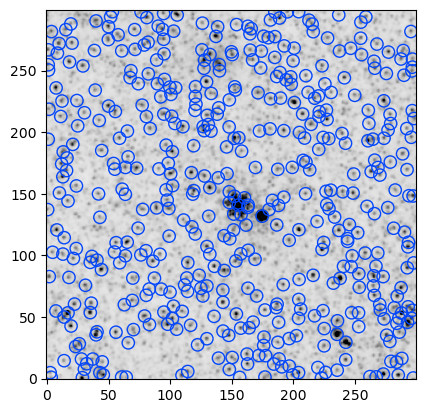


Adding [1, 1] pixel correction to x & y coordinates.
Please double-check accuracy of region file!
Saving testing_1M66_daofind_f200w_nircam_img.reg
testing_1M66_daofind_f200w_nircam_img.reg saved!


In [ ]:

from XRBID.WriteScript import WriteReg

data = fits.getdata(f200w)
data = data[3200:3500, 3000:3300]
pixtoarcs = 0.031 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.14
gal = "M66"
filter = "F200W"
instrument = "NIRCAM"
suffix = ''

reg_correction = [1, 1]

objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=True, vmax=10)

if reg_correction == False:
    xcoord_img = objects['xcentroid'].tolist()
    ycoord_img = objects['ycentroid'].tolist()
else: 
    print("\nAdding",reg_correction,"pixel correction to x & y coordinates.\nPlease double-check accuracy of region file!")
    xcoord_img = [x+reg_correction[0] for x in objects['xcentroid'].tolist()]
    ycoord_img = [y+reg_correction[1] for y in objects['ycentroid'].tolist()]

WriteReg(sources=[xcoord_img, ycoord_img], radius=3, coordsys="image", \
    	     outfile="testing_1"+gal+"_daofind_"+filter.lower()+"_"+instrument.lower()+suffix+"_img.reg", \
    	     label=objects["id"].tolist())

In [ ]:
# so this is workingz
from XRBID.WriteScript import WriteReg

objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=True, vmax=10)

if reg_correction == False:
    xcoord_img = objects['xcentroid'].tolist()
    ycoord_img = objects['ycentroid'].tolist()
else: 
    print("\nAdding",reg_correction,"pixel correction to x & y coordinates.\nPlease double-check accuracy of region file!")
    xcoord_img = [x+reg_correction[0] for x in objects['xcentroid'].tolist()]
    ycoord_img = [y+reg_correction[1] for y in objects['ycentroid'].tolist()]

WriteReg(sources=[xcoord_img, ycoord_img], radius=3, coordsys="image", \
    	     outfile="testing_1"+gal+"_daofind_"+filter.lower()+"_"+instrument.lower()+suffix+"_img.reg", \
    	     label=objects["id"].tolist())

In [ ]:
# The image file created by this code aligns pretty well with the sources detected by daofind. 
# Need to experiment with how the fk5 file is being made.
hdu = fits.open(f200w)
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])
RunPhots(hdu, gal='M66', instrument='NIRCAM', filter='F200W', fwhm_arcs=0.14,
         zeropoint=zeropoint, reg_correction=[1,1], aperture_correction=False, extended_rad=10)

In [ ]:
from astropy.wcs import WCS
hdu = fits.open(f200w)
wcs = WCS(hdu['SCI'].header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 170.0586200432 12.982711881 
CRPIX : 3525.8943134895 4747.3553156371 
PC1_1 PC1_2  : -0.99999999899233 -4.4904054395071e-05 
PC2_1 PC2_2  : -4.4903987494157e-05 0.99999999839656 
CDELT : 8.5413754476847e-06 8.5413754476847e-06 
NAXIS : 7051  9490

In [ ]:
hst = fits.open("/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66_test/HST_incomplete/M66_mosaic_acs_f814w_drc_sci.fits")
wcs = WCS(hst['PRIMARY'].header)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 170.05904927899854 12.991740862812955 
CRPIX : 3429.0997075228083 3418.640434895877 
CD1_1 CD1_2  : -1.1005555796954e-05 2.45315463060052e-22 
CD2_1 CD2_2  : 2.14619314433631e-22 1.10055557969543e-05 
NAXIS : 6856  6836

In [ ]:
from XRBID.WriteScript import WriteReg
from astropy.wcs import WCS

cd('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/test')

data = fits.getdata(f200w)
# data = data[3200:3500, 3000:3300]
pixtoarcs = 0.031 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.14
gal = "M66"
filter = "F200W"
instrument = "NIRCAM"
suffix = ''

reg_correction = [1, 1]

objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=False, vmax=10)
hdu = fits.open(f200w)


if reg_correction == False:
    xcoord_img = objects['xcentroid'].tolist()
    ycoord_img = objects['ycentroid'].tolist()
else: 
    print("\nAdding",reg_correction,"pixel correction to x & y coordinates.\nPlease double-check accuracy of region file!")
    xcoord_img = [x+reg_correction[0] for x in objects['xcentroid'].tolist()]
    ycoord_img = [y+reg_correction[1] for y in objects['ycentroid'].tolist()]


WriteReg(sources=[xcoord_img, ycoord_img], radius=3, coordsys="image", \
    	     outfile="writereg_test1_img.reg", \
    	     label=objects["id"].tolist())

wcs = WCS(hdu['SCI'].header)
xcoords_fk5, ycoords_fk5 = wcs.wcs_pix2world(xcoord_img, ycoord_img, 1)
WriteReg(sources=[xcoords_fk5, ycoords_fk5], coordsys="fk5", \
            outfile="writereg_test1_fk5.reg", \
            radius=0.15, radunit="arcsec", label=objects["id"].tolist())


Adding [1, 1] pixel correction to x & y coordinates.
Please double-check accuracy of region file!
Saving writereg_test1_img.reg
writereg_test1_img.reg saved!
Saving writereg_test1_fk5.reg
writereg_test1_fk5.reg saved!


In [ ]:
from XRBID.WriteScript import WriteReg
from astropy.wcs import WCS

cd('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/test')

data = fits.getdata(f300m)
# data = data[3200:3500, 3000:3300]
pixtoarcs = 0.063 # arcseconds for JWST Nircam short wavelength filters
fwhm = 0.10
gal = "M66"
filter = "F300mW"
instrument = "NIRCAM"
suffix = ''

reg_correction = [1, 1]

objects = DaoFindObjects(data, fwhm=fwhm, pixtoarcs=pixtoarcs, plot=False, vmax=10)
hdu = fits.open(f300m)


if reg_correction == False:
    xcoord_img = objects['xcentroid'].tolist()
    ycoord_img = objects['ycentroid'].tolist()
else: 
    print("\nAdding",reg_correction,"pixel correction to x & y coordinates.\nPlease double-check accuracy of region file!")
    xcoord_img = [x+reg_correction[0] for x in objects['xcentroid'].tolist()]
    ycoord_img = [y+reg_correction[1] for y in objects['ycentroid'].tolist()]


WriteReg(sources=[xcoord_img, ycoord_img], radius=3, coordsys="image", \
    	     outfile="f300m_writereg_test2_img.reg", \
    	     label=objects["id"].tolist())

wcs = WCS(hdu['SCI'].header)
xcoords_fk5, ycoords_fk5 = wcs.wcs_pix2world(xcoord_img, ycoord_img, 1)
WriteReg(sources=[xcoords_fk5, ycoords_fk5], coordsys="fk5", \
            outfile="f300m_writereg_test2_fk5.reg", \
            radius=0.15, radunit="arcsec", label=objects["id"].tolist())


Adding [1, 1] pixel correction to x & y coordinates.
Please double-check accuracy of region file!
Saving f300m_writereg_test2_img.reg
f300m_writereg_test2_img.reg saved!
Saving f300m_writereg_test2_fk5.reg
f300m_writereg_test2_fk5.reg saved!


In [ ]:
%%time 
zeropoint = np.mean([25.55, 25.56, 25.60, 25.66])
cd(jwstdir+'test')
hdu = fits.open(f200w)
RunPhots(hdu, gal='M66', fwhm_arcs=0.14, pixtoarcs=0.031, instrument='nircam',
         filter='F200W', zeropoint=zeropoint, num_stars=5, reg_correction=[1, 1], aperture_correction=False)

Using Zeropoint 25.5925
Using EEF: 0.925
Using pixtoarcs 0.031
Running DaoFind. This may take a while...

Adding [1, 1] pixel correction to x & y coordinates.
Please double-check accuracy of region file!
Saving M66_daofind_f200w_nircam_img.reg
M66_daofind_f200w_nircam_img.reg saved!
I am using method 2
Saving M66_daofind_f200w_nircam_fk5.reg
M66_daofind_f200w_nircam_fk5.reg saved!

 338494 sources found.
Background subtraction...
Photometry...
photometry_M66_f200w_nircam_full.ecsv saved
Time for full photometry: 2.397935231526693 minutes
Time for source photometry: 0.06573548316955566 minutes
Time for extended photometry: 0.08657071193059286 minutes
Calculating magnitudes...
photometry_M66_f200w_nircam_sources.ecsv saved
photometry_M66_f200w_nircam_extended.ecsv saved
DONE!
CPU times: user 2min 28s, sys: 19.5 s, total: 2min 48s
Wall time: 2min 53s


## Testing the identification of optical counterparts

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob
import shutil

from astroquery.mast import Observations
from astropy.io import fits

from XRBID.AutoPhots import RunPhots, DaoFindObjects
from XRBID.WriteScript import WriteReg
from XRBID.Sources import (LoadSources, GetCoords, GetIDs,
                           DaoClean, Crossref)
from XRBID.DataFrameMod import (RemoveElse, FindUnique, BuildFrame,
                                Find)
from XRBID.Align import CorrectAstrometry, CalcPU

from photometry_utils import instrument_info

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"

# Create a regions file
- create circular regions
- create text 

In [ ]:
from astropy.io import fits                     # for file handing 
from astropy.table import QTable                # for reading tables
from astropy.coordinates import SkyCoord, FK5   # for defining sky coordinates
import astropy.units as u                       # for using astronomical units (degs)
from regions import CircleSkyRegion, Regions    # for defining sky regions
from regions import TextSkyRegion               # for defining text regions

In [ ]:
# Read a BinTableHDU
cluster_hdu = fits.open('/Users/undergradstudent/Downloads/ngc3627/cluster/hlsp_phangs-cat_hst_wfc3_ngc3627_multi_v1_cluster-human-class12.fits')
clustertbl = QTable(cluster_hdu[1].data)
clustertbl

INDEX,ID_PHANGS_CLUSTERS,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_F275W_VEGA_TOT,PHANGS_F275W_VEGA_TOT_ERR,PHANGS_F336W_VEGA_TOT,PHANGS_F336W_VEGA_TOT_ERR,PHANGS_F438W_VEGA_TOT,PHANGS_F438W_VEGA_TOT_ERR,PHANGS_F555W_VEGA_TOT,PHANGS_F555W_VEGA_TOT_ERR,PHANGS_F814W_VEGA_TOT,PHANGS_F814W_VEGA_TOT_ERR,PHANGS_F275W_mJy_TOT,PHANGS_F275W_mJy_TOT_ERR,PHANGS_F336W_mJy_TOT,PHANGS_F336W_mJy_TOT_ERR,PHANGS_F438W_mJy_TOT,PHANGS_F438W_mJy_TOT_ERR,PHANGS_F555W_mJy_TOT,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy_TOT,PHANGS_F814W_mJy_TOT_ERR,PHANGS_CI,PHANGS_AGE_MINCHISQ,PHANGS_AGE_MINCHISQ_ERR,PHANGS_MASS_MINCHISQ,PHANGS_MASS_MINCHISQ_ERR,PHANGS_EBV_MINCHISQ,PHANGS_EBV_MINCHISQ_ERR,PHANGS_REDUCED_MINCHISQ,NO_DETECTION_FLAG
int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,14,6614.89,3239.51,170.06613550163783,12.939565672437887,1.0,2,0.9,20.64478245728906,0.02659657396351643,20.93979017654412,0.030188736564226437,22.250655300429276,0.031346415447021464,22.27859441730564,0.016875740045112282,22.11064764254441,0.03901893634778962,0.004894710575974825,0.00012002236400823634,0.005149012301279204,0.00014331060515183322,0.0051853476618246,0.00014985637672020489,0.004488303673158532,6.983200680382467e-05,0.003450014679669524,0.00012410973040724197,1.4406957552854887,1.0,1.0,8719.629993702069,2694.2879321260407,0.31,0.03999999999999998,0.15571900335067532,0.0
2,46,7284.4,3396.34,170.05857517129016,12.94129168906165,1.0,1,0.8,24.105332415990546,0.37037020453020186,22.714208348075548,0.08964678639377795,22.519651769070073,0.027672450452808608,21.668955157650842,0.009359068435449567,20.217371142107172,0.008528855229104975,0.0002020724158307192,6.900054767200979e-05,0.0010045155423948492,8.302346398363295e-05,0.004047429496485954,0.00010326101122819036,0.007869333245767959,6.790160231908834e-05,0.01973020252367809,0.00015514284407774865,1.6525453388887816,2440.0,1412.0,435789.158149563,132243.1815034949,0.15,0.17,0.6757897715262302,0.0
3,55,6620.99,3457.63,170.0660666598804,12.941966204158541,1.0,1,1.0,22.281918510623996,0.07737770478364059,22.22169363119243,0.0616848745282317,22.46988424208646,0.027246659028787583,22.442268805930635,0.014600834523023043,21.98812430101322,0.02959330849684471,0.001083608980805747,7.730327650696346e-05,0.0015811116822482226,8.991884008849886e-05,0.0042372716090699316,0.00010644101884595906,0.003860223743174932,5.196364647241765e-05,0.003862160160097809,0.00010537395092536263,1.5549336132831346,182.0,28.0,17467.385090088555,2360.828541606472,0.0,0.01,0.7982185920792995,0.0
4,68,6698.34,3482.21,170.06519319571672,12.942236733359024,1.0,1,1.0,20.82626233865763,0.02611063539413167,20.81526062516283,0.022289843866434313,21.009603537555332,0.010733207751301713,20.91452051154636,0.006500915802188716,20.38050871921674,0.009989056907406837,0.004141284477435931,9.969238081274846e-05,0.005774784072017913,0.00011867308687031326,0.01626292222205026,0.00016093021202070686,0.015765646894598556,9.449216496329995e-05,0.01697760840966834,0.00015635452786221064,1.7234222094582332,210.0,0.0,80145.11041876292,9281.609214165932,0.01,0.03,0.181573970260038,0.0
5,90,6745.89,3520.91,170.06465624597297,12.942662654573844,1.0,1,1.0,22.925218259744764,0.13452151333237802,22.27913233033862,0.06630949310249956,22.105464738627294,0.022063156905752657,21.881795724754113,0.012211765860952238,21.189383833152473,0.016662480049139786,0.0005991736362875742,7.431113649301165e-05,0.0014996401795385338,9.167950055632037e-05,0.005927261726618868,0.00012056776794817406,0.006468472112226721,7.282653409476053e-05,0.008059840858327328,0.00012381565857698675,1.8696595576630655,500.0,151.0,55569.664341832664,1130.107884178833,0.0,0.1,

In [ ]:
############# code for creating circular regions #############
regions = []
radius = 0.00005 * u.deg       # change this depending on the desired size of the radius
for i in range(len(clustertbl)):
    # create sky coordinates
    center_sky = SkyCoord(ra=clustertbl['PHANGS_RA'][i], dec=clustertbl['PHANGS_DEC'][i],
                          unit='deg', frame='icrs').transform_to(FK5)
    sky_reg = CircleSkyRegion(center=center_sky, radius=radius)
    regions.append(sky_reg)

regs = Regions(regions)
# regs.write("testing.reg", format='ds9')
regs

<Regions([<CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06614071, 12.93956223)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.05858038, 12.94128824)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06607187, 12.94196276)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06519841, 12.94223329)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06466146, 12.94265921)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.0652489, 12.94323424)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06312355, 12.94414244)>, radius=5e-05 deg)>, <CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in d

In [ ]:
############# code for creating textual regions #############

# Add a few degrees to the center coordinate of the source
# so that the region that is created would be above the source
clustercopy = clustertbl.copy()
clustercopy['PHANGS_DEC'] = clustercopy['PHANGS_DEC'] + 0.00005

regions = []
radius = 0.00008 * u.deg
for i in range(len(clustertbl)):
    center_sky = SkyCoord(ra=clustertbl['PHANGS_RA'][i], dec=clustercopy['PHANGS_DEC'][i],
                          unit='deg', frame='icrs').transform_to(FK5)
    sky_reg = TextSkyRegion(center=center_sky, text=clustertbl['ID_PHANGS_CLUSTERS'][i])
    regions.append(sky_reg)

regs = Regions(regions)
# regs.write("text_testing.reg", format='ds9')
regs


<Regions([<TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06614071, 12.93961223)>, text=np.int64(14))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.05858038, 12.94133824)>, text=np.int64(46))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06607187, 12.94201276)>, text=np.int64(55))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06519841, 12.94228329)>, text=np.int64(68))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06466146, 12.94270921)>, text=np.int64(90))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.0652489, 12.94328424)>, text=np.int64(112))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (170.06312355, 12.94419244)>, text=np.int64(148))>, <TextSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    

In [ ]:
def create_regions(data, xheader, yheader, radius=0.0008, unit='deg', frame='fk5', savefile=False, outfile=False, format='ds9'):
    regions = []     
    radius = radius * u.deg

    for i in range(len(data)):
        # create sky coordinates
        center_sky = SkyCoord(ra=data[xheader][i], dec=data[yheader][i],
                            unit='deg', frame='fk5')#transform_to(FK5)
        sky_reg = CircleSkyRegion(center=center_sky, radius=radius)
        regions.append(sky_reg)

    # Create Astropy Sky regions
    regs = Regions(regions)

    if savefile:
        print(f"Saving {outfile}\n")
        regs.write(outfile, format=format)
        print("Saved :)")
    return regs

def create_text_regions(data, xheader, yheader, textheader, radius=0.0008, shift=0.00005, unit='deg', frame='fk5', savefile=False, outfile=False, format='ds9'):
    text_regions = []
    radius = radius * u.deg

    temp = data.copy()
    temp[yheader] = data[yheader] + shift
    for i in range(len(data)):
        center_sky = SkyCoord(ra=data[xheader][i], dec=temp[yheader][i],
                            unit=unit, frame='fk5')#.transform_to(FK5)
        text_sky_reg = TextSkyRegion(center=center_sky, text=data[textheader][i])
        text_regions.append(sky_reg)

    text_regs = Regions(text_regions)
    
    if savefile:
        print(f"Saving {outfile} \n")
        regs_text.write(outfile, format='ds9')
        print(f"Saved :)")
    return text_regs


# snrcopy = snr_catalog.copy()
# snrcopy['Dec'] = snr_catalog['Dec'] + 0.00005

# text_regions = []
# radius = 0.00008 * u.deg
# for i in range(len(snr_catalog)):
#     center_sky = SkyCoord(ra=snr_catalog['RA'][i], dec=snrcopy['Dec'][i],
#                           unit='deg', frame='fk5')
#     text_sky_reg = TextSkyRegion(center=center_sky, text=snr_catalog['SNR ID'][i])
#     text_regions.append(sky_reg)


# text_regs = Regions(text_regions)
# regs_text.write(chandra_hst_dir+"cluster_catalog_text.reg", format='ds9')
# text_regs

# Looking at a full dataframe

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# If needed, control the width of columns to avoid line wrapping
pd.set_option('display.width', 1000)
# If needed, adjust the max column width
pd.set_option('display.max_colwidth', None)

In [ ]:
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
df = pd.read_csv(chandra_hst_dir+"M66_crossreffed_all.frame")
df

,Unnamed: 0,X,Y,CSC ID,Cluster ID,SNR ID
0,0,3728.392237,5731.691614,2CXO J112014.9+125929,NaN,NaN
1,1,3730.382900,5734.693669,2CXO J112014.9+125929,NaN,NaN
2,2,3690.922608,5713.903685,2CXO J112015.0+125928,NaN,NaN
3,3,3693.339708,5721.089782,2CXO J112015.0+125928,NaN,NaN
4,4,3746.714500,5828.653600,2CXO J112014.9+125933,NaN,NaN
5,5,3743.843919,5833.507868,2CXO J112014.9+125933,NaN,NaN
6,6,3631.498024,5707.196545,2CXO J112015.2+125932X,NaN,NaN
7,7,3616.657886,5709.020478,2CXO J112015.2+125932X,NaN,NaN
8,8,3645.328026,5715.614054,2CXO J112015.2+125932X,NaN,NaN
9,9,3645.328026,5715.614054,2CXO J112015.2+125932X,NaN,NaN


# Testing DaoCleanMatch

In [ ]:
x,y = GetCoords(jwstdir+"M66_daofind_f200w_nircam_img.reg")
ids = GetIDs(jwstdir+"M66_daofind_f200w_nircam_img.reg")
ra,dec = GetCoords(jwstdir+"M66_daofind_f200w_nircam_fk5.reg")

# # Compiling into a single DataFrame
DaoFrame = BuildFrame(headers=['DaoID','X','Y','RA','Dec'], 
                      values=[ids,x,y,ra,dec])
# DaoFrame.to_csv(jwstdir+"M66_daofind_nircam_coords.frame")

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_img.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_img.reg
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/M66_daofind_f200w_nircam_fk5.reg


In [ ]:
# DaoFrame = pd.read_csv(jwstdir+"M66_daofind_nircam_coords.frame").drop("Unnamed: 0", axis=1)
display(DaoFrame)

,DaoID,X,Y,RA,Dec
0,1,2924.060015,17.233289,170.063905,12.942310
1,2,2935.948938,16.743024,170.063801,12.942306
2,3,2940.043395,24.122714,170.063765,12.942369
3,4,2913.002787,24.673854,170.064002,12.942374
4,5,2928.996433,27.917984,170.063862,12.942402
...,...,...,...,...,...
338489,338490,4209.310007,9462.788748,170.052636,13.022988
338490,338491,4182.418343,9464.476210,170.052871,13.023002
338491,338492,4217.247604,9468.846438,170.052566,13.023040
338492,338493,4190.522509,9471.099783,170.052800,13.023059


In [ ]:
cd(chandra_jwst_dir)
M66_best = LoadSources("M66_csc_bestrads.frame")

# Reading in the newly-saved img region file
xsources, ysources = GetCoords("M66_bestrads_2sig.reg")
# Adding the image coordinates to the DataFrame
M66_best["X"] = xsources
M66_best["Y"] = ysources

# Convert the radius from arcseconds to pixels. 
# The conversion is 0.05 for ACS/WFC and 0.03962 for WFC3/UVIS
# The conversion is 0.031 for short wavelength and 0.062 for long wavelength
# filters in JWST
M66_best["2Sig (pix)"] = M66_best["2Sig"] / 0.031  # f200w is a short wavelength filter

# Saving the changes to the DataFrame
# M66_best.to_csv("M66_csc_bestrads.frame")
display(M66_best)

Reading in sources from M66_csc_bestrads.frame...
Retrieving coordinates from M66_bestrads_2sig.reg


,Separation,CSC ID,RA,Dec,Err Ellipse Major,Err Ellipse Minor,Err Ellipse Angle,Significance,Likelihood,conf_flag,...,Theta,HS Ratio,Counts,Counts lolim,Counts hilim,1Sig,2Sig,X,Y,2Sig (pix)
0,0.603512,2CXO J112014.9+125929,170.062428,12.991495,0.311932,0.311917,0.000000,9.567092,TRUE,True,...,0.420311,0.029981,173.048934,154.988228,191.109641,0.094820,0.199755,170.062428,12.991495,6.443720
1,1.154310,2CXO J112015.0+125928,170.062878,12.991329,0.317501,0.317501,0.000000,7.701153,TRUE,True,...,0.412041,-0.277327,126.386565,109.441688,142.201784,0.098572,0.211250,170.062878,12.991329,6.814523
2,4.249587,2CXO J112014.9+125933,170.062259,12.992633,0.299684,0.298357,5.587902,12.795398,TRUE,False,...,0.488407,0.224859,226.842541,209.119065,244.566017,0.093299,0.195763,170.062259,12.992633,6.314923
3,4.484088,2CXO J112015.2+125932X,170.063665,12.992189,3.446421,3.446421,0.000000,39.744111,TRUE,NaN,...,0.466503,NaN,3329.616280,3231.522180,3427.710381,1.724639,3.449278,170.063665,12.992189,111.267026
4,5.940189,2CXO J112015.3+125932,170.064119,12.992230,0.413187,0.343140,64.093176,5.142857,TRUE,False,...,0.477466,0.199875,39.229231,31.383385,46.639197,0.139549,0.319405,170.064119,12.992230,10.303379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,231.679093,2CXO J112030.5+130013,170.127457,13.003663,1.402157,0.820192,1.489236,3.575758,TRUE,False,...,3.984317,0.201124,18.342335,13.057255,23.316527,0.434283,1.063647,170.127457,13.003663,34.311184
84,237.496980,2CXO J112008.5+130307,170.035399,13.051914,0.774353,0.647498,139.851620,4.000000,TRUE,False,...,4.338261,0.463460,24.421586,18.316189,30.526982,0.418108,1.014080,170.035399,13.051914,32.712258
85,240.218881,2CXO J112019.6+130320,170.081736,13.055570,0.563631,0.427724,157.623228,10.427182,TRUE,False,...,4.414767,0.763273,150.478203,136.047662,164.908744,0.183118,0.383024,170.081736,13.055570,12.355608
86,246.797558,2CXO J112027.8+125649,170.116113,12.946999,1.754478,1.143646,33.705932,3.294118,TRUE,False,...,3.872333,-0.408495,17.434501,12.141885,22.727118,0.431766,1.059103,170.116113,12.946999,34.164619


In [ ]:
DaoCleanFrame = DaoClean(daosources=DaoFrame, sources=M66_best, sourceid="CSC ID", 
                         coordsys="fk5", coordheads=['RA', 'Dec'], radheader="2Sig") 

# Renaming the DaoID header to "F555W ID", to match the output of the other filters
DaoCleanFrame = DaoCleanFrame.rename(columns={'DaoID': 'F200W ID'})

display(DaoCleanFrame)

# WriteReg(DaoCleanFrame, coordsys='fk5', width=2,
#          outfile='M66_daoclean_f200w_nircam_fk5.reg',
#          radius=0.1, radunit='arcsec')

Cleaning DAOFind sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,F200W ID,X,Y,RA,Dec,CSC ID
0,186126,3095.278143,5769.996064,170.062403,12.991447,2CXO J112014.9+125929
1,186591,3098.298769,5777.274662,170.062377,12.991509,2CXO J112014.9+125929
2,185199,3035.930921,5754.396561,170.062923,12.991314,2CXO J112015.0+125928
3,185366,3042.938275,5757.419244,170.062862,12.991339,2CXO J112015.0+125928
4,185433,3035.951387,5759.029222,170.062923,12.991353,2CXO J112015.0+125928
...,...,...,...,...,...,...
1353,26276,4034.543404,2097.590954,170.054172,12.960079,2CXO J112013.0+125736
1354,26305,4021.687783,2099.17956,170.054284,12.960093,2CXO J112013.0+125736
1355,26519,4032.312552,2109.128343,170.054191,12.960178,2CXO J112013.0+125736
1356,26624,4024.074667,2114.406991,170.054263,12.960223,2CXO J112013.0+125736


In [ ]:
%%time
cd(jwstdir)
regions = ['M66_daofind_f300m_nircam_fk5.reg',
           'M66_daofind_f335m_nircam_fk5.reg',
           'M66_daofind_f360m_nircam_fk5.reg']
DaoCleanMatch = Crossref(DaoCleanFrame, 
                         regions=regions, 
                         catalogs=['F300M', 'F335M', 'F360M'], coordheads=['RA','Dec'], 
                         sourceid="F200W ID", outfile=chandra_jwst_dir+"M66_daoclean_matches_test.frame")

DaoCleanMatch

Finding cross-references between sources. This will take a few minutes. Please wait.. 


# Loop through the XRB images and plot them and then ask the user to enter its classification. 

This code needs further modification

In [ ]:
import matplotlib.image as mpimg
cd(chandra_hst_dir+'XRB_images')
# images = ['M66_XRB_candidates_CXO004_env.png', 
#           'M66_XRB_candidates_CXO005_env.png',
#           'M66_XRB_candidates_CXO006_env.png', 
#           'M66_XRB_candidates_CXO007_env.png']
#
# image_path = chandra_hst_dir+'XRB_images/M66_XRB_candidates_CXO004_env.png'
# images = glob.glob(chandra_hst_dir+'XRB_images/*_env.png')
# image = mpimg.imread(image_path)
# plt.imshow(image)
# plt.show()
# for img in images:
#     image = mpimg.imread(img)
#     plt.imshow(image)
    # plt.show()

images = glob.glob(chandra_hst_dir+'XRB_images/*.png')
for image in images:
    if 
images.sort()
for img in images:
    image = mpimg.imread(img)
    plt.imshow(image)
    # plt.title(img)
    plt.show()

In [ ]:
from XRBID.XRTools import Lum

In [ ]:
M66_notes = pd.read_csv(chandra_hst_dir+"M66_XRB_notes.txt")

for i, img in enumerate(zoomed_images):
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.title(img)
    plt.show()

    M66_notes['Class'][i] = input("Enter Class of XRB candidate:")
    M66_notes['Star'][i] = input ("Enter the best star:")

# Code to remove the Unnamed column in a dataframe

In [ ]:
from XRBID.Sources import LoadSources

x = LoadSources(chandra_hst_dir+"M66_XRB_notes.txt")
x

Reading in sources from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_XRB_notes.txt...


,Unnamed: 0.1,CSC ID,ID,Class,Best Star,Mass,Notes
0,0,2CXO J112014.9+125929,CXO001,Nucleus,2.0,NaN,NaN
1,1,2CXO J112015.0+125928,CXO002,Compact Association,1.0,NaN,PHANGS-WFC3 Compact Assoc 16 pc ID 2733
2,2,2CXO J112014.9+125933,CXO003,HMXB,2.0,NaN,NaN
3,4,2CXO J112015.3+125932,CXO005,LMXB,NaN,NaN,Optical Counterpart not observed with HST
4,5,2CXO J112015.0+125936,CXO006,HMXB,1.0,NaN,NaN
5,6,2CXO J112015.0+125921,CXO007,HMXB,1.0,NaN,NaN
6,7,2CXO J112015.2+125921,CXO008,HMXB,2.0,NaN,NaN
7,8,2CXO J112014.7+125937,CXO009,HMXB,1.0,NaN,NaN
8,9,2CXO J112015.0+125938,CXO010,HMXB,1.0,NaN,NaN
9,10,2CXO J112014.2+125927,CXO011,LMXB,NaN,NaN,Optical Counterpart not observed with HST


In [ ]:
# The magic command and voila
x = x.loc[:, ~x.columns.str.contains('^Unnamed')]
display(x)

,CSC ID,ID,Class,Best Star,Mass,Notes
0,2CXO J112014.9+125929,CXO001,Nucleus,2.0,NaN,NaN
1,2CXO J112015.0+125928,CXO002,Compact Association,1.0,NaN,PHANGS-WFC3 Compact Assoc 16 pc ID 2733
2,2CXO J112014.9+125933,CXO003,HMXB,2.0,NaN,NaN
3,2CXO J112015.3+125932,CXO005,LMXB,NaN,NaN,Optical Counterpart not observed with HST
4,2CXO J112015.0+125936,CXO006,HMXB,1.0,NaN,NaN
5,2CXO J112015.0+125921,CXO007,HMXB,1.0,NaN,NaN
6,2CXO J112015.2+125921,CXO008,HMXB,2.0,NaN,NaN
7,2CXO J112014.7+125937,CXO009,HMXB,1.0,NaN,NaN
8,2CXO J112015.0+125938,CXO010,HMXB,1.0,NaN,NaN
9,2CXO J112014.2+125927,CXO011,LMXB,NaN,NaN,Optical Counterpart not observed with HST


# Phangs cluster and compact association catalogs

In [ ]:
cassoc_16pc = pd.read_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/assoc_catalog_ws16pc.frame')
cassoc_32pc = pd.read_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/assoc_catalog_ws32pc.frame')
cassoc_64pc = pd.read_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/assoc_catalog_ws64pc.frame')
cassoc_acs = pd.read_csv('/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc_catalog_acs-uvis.frame')

In [ ]:
cassoc_16pc.shape, cassoc_32pc.shape, cassoc_64pc.shape, cassoc_acs.shape

((4244, 37), (3097, 37), (1467, 37), (184, 38))

# Testing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from XRBID.DataFrameMod import Find
from XRBID.Sources import Crossref, GetCoords

import os, sys
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
cd = os.chdir

from helpers.analysis import remove_unnamed, XrayBinary, compare_dfs
from helpers.regions import WriteReg

hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/"

# cluster catalogs from the PHANGS catalogs
cluster_cataglog_wfc3 = pd.read_csv(chandra_hst_dir+"M66_cluster_catalog_uvis_fk5.frame")
compact_assoc_16pc = pd.read_csv(chandra_hst_dir+"assoc_catalog_ws16pc.frame")           # uses 16 pc watershed algorithm 
compact_assoc_acs = pd.read_csv(chandra_hst_dir+"M66_assoc_catalog_acs-uvis.frame")

daoclean = remove_unnamed(pd.read_csv(chandra_hst_dir+"M66_daoclean_matches.frame"))
M66_notes = remove_unnamed(pd.read_csv(chandra_hst_dir+"M66_XRB_notes.txt"))

# Only crossref sources that correspond to an XRB with an optical counterpart
M66_sources = Find(M66_notes, ['Class != LMXB',
                               'Class != Foreground Star',
                               'Class != Nucleus'])

best_stars = compare_dfs(daoclean, M66_sources, 
                         'CSC ID', ['StarID', 'Best Star'])

regions = [
    chandra_hst_dir+"M66_cluster_catalog_fk5.reg",
    chandra_hst_dir+"M66_assoc1_catalog_ws16pc_fk5.reg",
    chandra_hst_dir+"M66_assoc_catalog_acs-uvis_fk5.reg"
]

In [ ]:
cluster_reg = [
    chandra_hst_dir+"M66_assoc1_catalog_ws16pc_fk5.reg",
    chandra_hst_dir+"M66_assoc_catalog_acs-uvis_fk5.reg"
]

catalogs = ['wfc3', 'acs']

ca_crossref = Crossref(
    df=best_stars[:10],
    regions=cluster_reg,
    catalogs=catalogs,
    sourceid='CSC ID',
    search_radius=0.0005,
    coordsys='fk5',
    coordheads=['RA', 'Dec'],
    outfile='/Users/undergradstudent/Downloads/test_crossref.txt'
)

display(ca_crossref)

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...


,RA,Dec,CSC ID,wfc3 ID,acs ID,X,Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,StarID
0,170.062890,12.991310,2CXO J112015.0+125928,2710.0,NaN,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,1
1,170.062890,12.991310,2CXO J112015.0+125928,2724.0,NaN,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,1
2,170.062890,12.991310,2CXO J112015.0+125928,2730.0,NaN,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,1
3,170.062890,12.991310,2CXO J112015.0+125928,2733.0,NaN,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,1
4,170.062890,12.991310,2CXO J112015.0+125928,2739.0,NaN,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,1
5,170.062890,12.991310,2CXO J112015.0+125928,2740.0,NaN,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,1
6,170.062890,12.991310,2CXO J112015.0+125928,2756.0,NaN,3690.922608,5713.903685,18254,NaN,95118.0,34583.0,NaN,1
7,170.062292,12.992626,2CXO J112014.9+125933,NaN,NaN,3743.843919,5833.507868,19247,130956.0,NaN,36055.0,NaN,2
8,170.062784,12.993454,2CXO J112015.0+125936,NaN,NaN,3700.317585,5908.701948,19792,NaN,NaN,36916.0,NaN,1
9,170.062475,12.989172,2CXO J112015.0+125921,NaN,NaN,3727.624318,5519.646556,16435,NaN,NaN,NaN,NaN,1


In [ ]:
best_stars.columns

Index(['X', 'Y', 'F555W ID', 'F275W ID', 'F336W ID', 'F438W ID', 'F814W ID',
       'RA', 'Dec', 'CSC ID', 'StarID'],
      dtype='object')

In [ ]:
ca_crossref['wfc3 ID'][0], type(temp['acs ID'][0])

(np.float64(2710.0), str)

In [ ]:
ra, dec = GetCoords(cluster_reg[0])
id = GetIDs(cluster_reg[0])

test = pd.DataFrame()
test['RA'] = ra

test['RA'][0]

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc1_catalog_ws16pc_fk5.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc1_catalog_ws16pc_fk5.reg


np.float64(170.05743359320334)

In [ ]:
from XRBID.Sources import GetIDs, GetCoords

ca_crossref['wfc3 RA'] = ''
ca_crossref['wfc3 Dec'] = ''
ca_crossref['acs RA'] = ''
ca_crossref['acs Dec'] = ''
for catalog, region in zip(catalogs, cluster_reg):
    ra, dec = GetCoords(region)
    id = GetIDs(region)
    temp = pd.DataFrame()
    # temp[f'{catalog} ID'] = id
    # temp[f'{catalog} RA'] = ra
    # temp[f'{catalog} Dec'] = dec

    temp['RA'] = ra
    temp['Dec'] = dec
    temp['ID'] = id
    temp['ID'] = temp['ID'].astype(float)

    for index, row in ca_crossref.iterrows():
        for index1, row1 in temp.iterrows():
            if ca_crossref[f'{catalog} ID'][index] == temp['ID'][index1]:
                print("found")

Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc1_catalog_ws16pc_fk5.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc1_catalog_ws16pc_fk5.reg
found
found
found
found
found
found
found
found
found
found
found
found
found
Retrieving coordinates from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc_catalog_acs-uvis_fk5.reg
Retrieving IDs from /Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/M66_assoc_catalog_acs-uvis_fk5.reg


In [ ]:
temp['ID'][1], ca_crossref['wfc3 ID'][0]

(np.float64(750.0), np.float64(2710.0))

# Testing

In [4]:
M66_xrbs = remove_unnamed(pd.read_csv(M66_dir+"XRB-ejection/M66_hst_jwst_xrbs_photometry.csv"))

In [5]:
cscid1 = '2CXO J112014.9+125933'
source1 = M66_xrbs.query(f'`CSC ID` == "{cscid1}"')
source1

,CSC ID,RA,Dec,JWST ID,HST ID,F2000W ID,F3000M ID,F3350M ID,F3600M ID,F275W ID,F336W ID,F438W ID,F555W ID,F814W ID,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,Class,Flag,Notes,Star ID,ID,Auxiliary ID
0,2CXO J112014.9+125933,170.062313,12.992598,1,2.0,194701,45185.0,NaN,NaN,130956.0,NaN,36055.0,19247.0,NaN,-12.309132,-0.925911,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,NaN,NaN,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,HMXB,NaN,NaN,NaN,NaN,2CXO J112014.9+125933-1-2.0
1,2CXO J112014.9+125933,170.062307,12.992623,3,2.0,194908,45185.0,NaN,NaN,130956.0,NaN,36055.0,19247.0,NaN,-12.319953,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,NaN,NaN,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,HMXB,NaN,NaN,NaN,NaN,2CXO J112014.9+125933-3-2.0
2,2CXO J112014.9+125933,170.062255,12.992622,4,2.0,194909,NaN,NaN,NaN,130956.0,NaN,36055.0,19247.0,NaN,-12.429364,-0.794376,NaN,NaN,NaN,NaN,NaN,NaN,-2.974469,-1.372681,NaN,NaN,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,HMXB,NaN,NaN,NaN,NaN,2CXO J112014.9+125933-4-2.0


Finding best-fit model(s)...
DONE


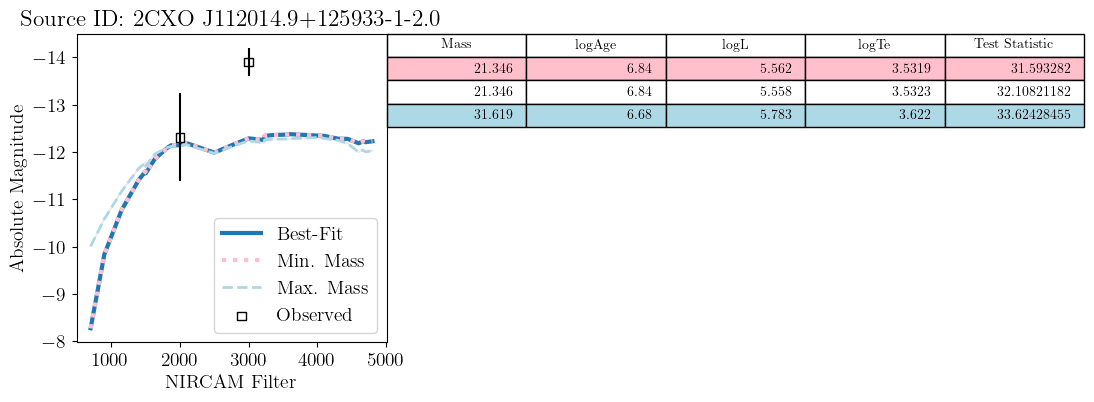

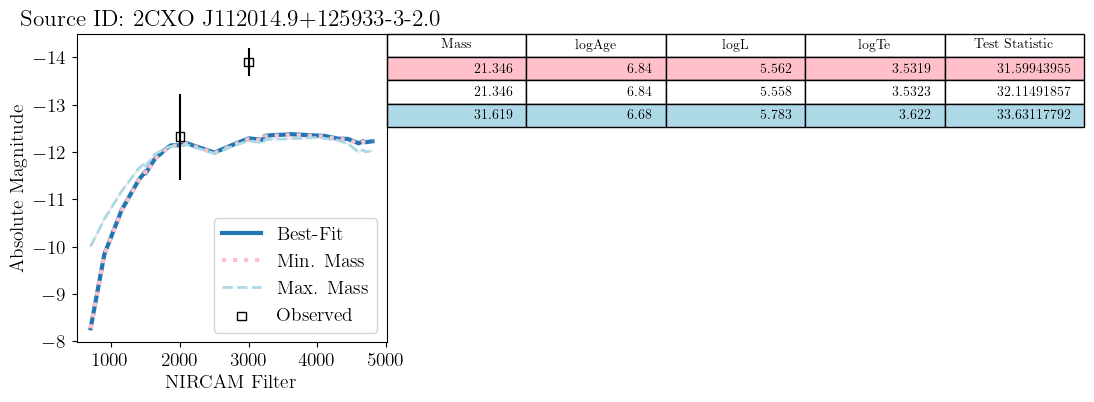

No best-fit model available for Source ID 2CXO J112014.9+125933-4-2.0.


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbol,F700W,F900W,F1150W,F1500W,F2000W,F2770W,F3560W,F4440W,F1500W2,F3220W2,F1400M,F1620M,F1820M,F2100M,F2500M,F3000M,F3350M,F3600M,F4100M,F4300M,F4600M,F4800M,F1640N,F1870N,F2120N,F3230N,F4050N,F4660N,F4700N,Test Statistic,Auxiliary ID
0,0.0152,0.01508,6.84,27.632059,2.631785,21.346,5.562,3.5319,-0.715,3,0.0,0.330,1239.08,679.76,418.37,307.71,258.17,0,-0.000018,0.0,0.5677,0.4171,0.000944,0.005384,0.003804,-1.0,0.01523,-9.135,-8.274,-9.837,-10.768,-11.590,-12.141,-12.153,-12.367,-12.276,-11.546,-12.252,-11.410,-11.821,-12.092,-12.186,-11.986,-12.287,-12.356,-12.375,-12.339,-12.280,-12.182,-12.224,-11.859,-12.140,-12.174,-12.339,-12.342,-12.224,-12.206,31.593282,2CXO J112014.9+125933-1-2.0
1,0.0152,0.01508,6.84,27.630604,2.631785,21.346,5.558,3.5323,-0.709,3,0.0,0.330,1228.34,672.90,414.34,304.70,255.64,0,-0.000018,0.0,0.5678,0.4169,0.000945,0.005379,0.003808,-1.0,0.01523,-9.124,-8.274,-9.829,-10.757,-11.578,-12.129,-12.140,-12.353,-12.263,-11.534,-12.239,-11.398,-11.809,-12.079,-12.173,-11.973,-12.274,-12.343,-12.362,-12.326,-12.267,-12.168,-12.210,-11.847,-12.127,-12.162,-12.326,-12.329,-12.211,-12.193,32.108212,2CXO J112014.9+125933-1-2.0
2,0.0152,0.01508,6.68,40.000000,2.632607,31.619,5.783,3.6220,-0.405,1,0.0,0.443,0.00,0.00,0.00,0.00,0.00,-1,-0.000037,0.0,0.6013,0.3835,0.001095,0.005683,0.003222,-1.0,0.01513,-9.688,-10.005,-10.584,-11.166,-11.772,-12.125,-12.120,-12.274,-12.176,-11.693,-12.190,-11.654,-11.936,-12.096,-12.155,-11.970,-12.236,-12.268,-12.279,-12.285,-12.246,-11.996,-12.028,-11.961,-12.117,-12.140,-12.255,-12.307,-12.042,-12.000,33.624285,2CXO J112014.9+125933-1-2.0
3,0.0152,0.01508,6.68,40.000000,2.632607,31.619,5.783,3.6220,-0.405,1,0.0,0.443,0.00,0.00,0.00,0.00,0.00,-1,-0.000037,0.0,0.6013,0.3835,0.001095,0.005683,0.003222,-1.0,0.01513,-9.688,-10.005,-10.584,-11.166,-11.772,-12.125,-12.120,-12.274,-12.176,-11.693,-12.190,-11.654,-11.936,-12.096,-12.155,-11.970,-12.236,-12.268,-12.279,-12.285,-12.246,-11.996,-12.028,-11.961,-12.117,-12.140,-12.255,-12.307,-12.042,-12.000,33.631178,2CXO J112014.9+125933-3-2.0
4,0.0152,0.01508,6.84,27.630604,2.631785,21.346,5.558,3.5323,-0.709,3,0.0,0.330,1228.34,672.90,414.34,304.70,255.64,0,-0.000018,0.0,0.5678,0.4169,0.000945,0.005379,0.003808,-1.0,0.01523,-9.124,-8.274,-9.829,-10.757,-11.578,-12.129,-12.140,-12.353,-12.263,-11.534,-12.239,-11.398,-11.809,-12.079,-12.173,-11.973,-12.274,-12.343,-12.362,-12.326,-12.267,-12.168,-12.210,-11.847,-12.127,-12.162,-12.326,-12.329,-12.211,-12.193,32.114919,2CXO J112014.9+125933-3-2.0
5,0.0152,0.01508,6.84,27.632059,2.631785,21.346,5.562,3.5319,-0.715,3,0.0,0.330,1239.08,679.76,418.37,307.71,258.17,0,-0.000018,0.0,0.5677,0.4171,0.000944,0.005384,0.003804,-1.0,0.01523,-9.135,-8.274,-9.837,-10.768,-11.590,-12.141,-12.153,-12.367,-12.276,-11.546,-12.252,-11.410,-11.821,-12.092,-12.186,-11.986,-12.287,-12.356,-12.375,-12.339,-12.280,-12.182,-12.224,-11.859,-12.140,-12.174,-12.339,-12.342,-12.224,-12.206,31.599440,2CXO J112014.9+125933-3-2.0


In [6]:
bestfit1_jwst = FitSED(
    df=source1,
    instrument='nircam',
    idheader='Auxiliary ID',
    plotSED=True,
    min_models=3
)

display(bestfit1_jwst)

Finding best-fit model(s)...
DONE


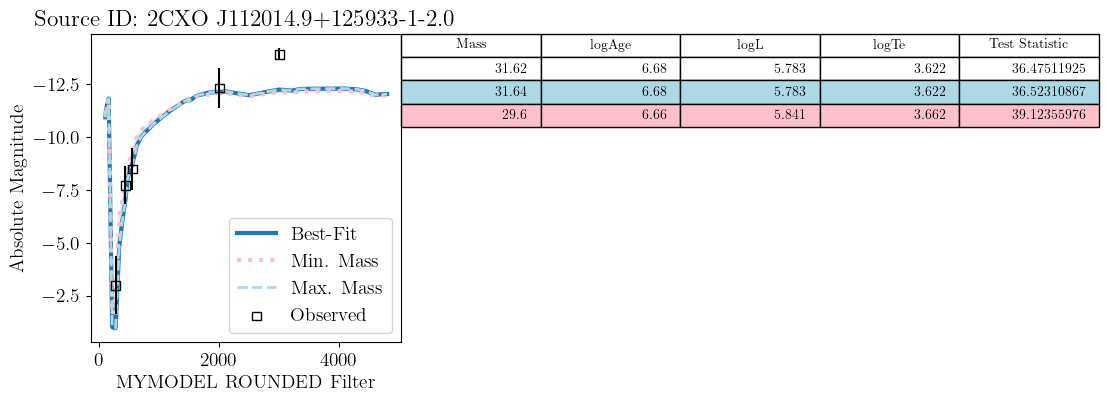

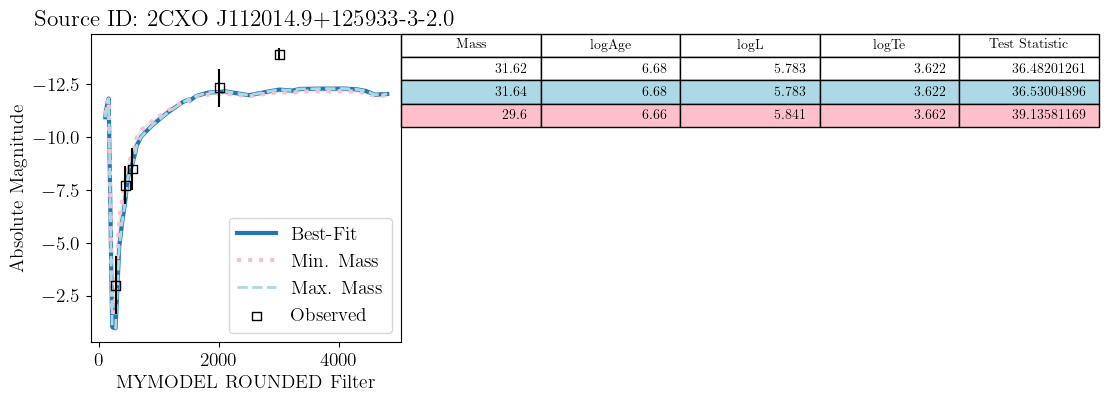

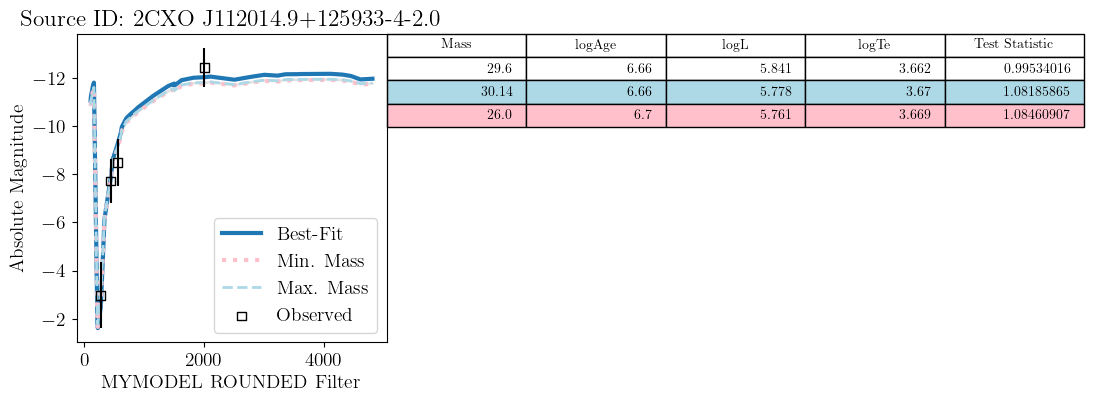

,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbol_x,F218W,F225W,F275W,F336W,F390W,F438W,F475W,F555W,F606W,F625W,F775W,F814W,F105W,F110W,F125W,F140W,F160W,mbol_y,F700W,F900W,F1150W,F1500W,F2000W,F2770W,F3560W,F4440W,F1500W2,F3220W2,F1400M,F1620M,F1820M,F2100M,F2500M,F3000M,F3350M,F3600M,F4100M,F4300M,F4600M,F4800M,Test Statistic,Auxiliary ID
0,0.0152,0.01508,6.68,40.000,2.63,31.62,5.783,3.622,-0.405,1,0.0,0.443,0.0,0.0,0.0,0.0,0.0,-1,-0.00004,0.0,0.6013,0.3835,0.001095,0.005683,0.003222,-1.0,0.01513,-9.688,-1.049,-0.990,-0.952,-4.811,-6.079,-7.012,-8.017,-8.741,-9.275,-9.568,-10.232,-10.338,-10.926,-11.138,-11.367,-11.612,-11.814,-9.688,-10.005,-10.584,-11.166,-11.772,-12.125,-12.120,-12.274,-12.176,-11.693,-12.190,-11.654,-11.936,-12.096,-12.155,-11.970,-12.236,-12.268,-12.279,-12.285,-12.246,-11.996,-12.028,36.475119,2CXO J112014.9+125933-1-2.0
1,0.0152,0.01508,6.68,40.000,2.63,31.62,5.783,3.622,-0.405,1,0.0,0.443,0.0,0.0,0.0,0.0,0.0,-1,-0.00004,0.0,0.6013,0.3835,0.001095,0.005683,0.003222,-1.0,0.01513,-9.688,-1.049,-0.990,-0.952,-4.811,-6.079,-7.012,-8.017,-8.741,-9.275,-9.568,-10.232,-10.338,-10.926,-11.138,-11.367,-11.612,-11.814,-9.688,-10.005,-10.584,-11.166,-11.772,-12.125,-12.120,-12.274,-12.176,-11.693,-12.190,-11.654,-11.936,-12.096,-12.155,-11.970,-12.236,-12.268,-12.279,-12.285,-12.246,-11.996,-12.028,36.482013,2CXO J112014.9+125933-3-2.0
2,0.0152,0.01508,6.68,39.996,2.63,31.64,5.783,3.622,-0.405,1,0.0,0.443,0.0,0.0,0.0,0.0,0.0,-1,-0.00004,0.0,0.6014,0.3834,0.001096,0.005680,0.003225,-1.0,0.01513,-9.687,-1.047,-0.989,-0.950,-4.809,-6.077,-7.010,-8.016,-8.740,-9.274,-9.567,-10.231,-10.337,-10.925,-11.137,-11.366,-11.611,-11.813,-9.687,-10.004,-10.584,-11.165,-11.771,-12.124,-12.119,-12.273,-12.176,-11.692,-12.190,-11.653,-11.936,-12.095,-12.155,-11.969,-12.235,-12.268,-12.278,-12.285,-12.246,-11.995,-12.028,36.523109,2CXO J112014.9+125933-1-2.0
3,0.0152,0.01508,6.68,39.996,2.63,31.64,5.783,3.622,-0.405,1,0.0,0.443,0.0,0.0,0.0,0.0,0.0,-1,-0.00004,0.0,0.6014,0.3834,0.001096,0.005680,0.003225,-1.0,0.01513,-9.687,-1.047,-0.989,-0.950,-4.809,-6.077,-7.010,-8.016,-8.740,-9.274,-9.567,-10.231,-10.337,-10.925,-11.137,-11.366,-11.611,-11.813,-9.687,-10.004,-10.584,-11.165,-11.771,-12.124,-12.119,-12.273,-12.176,-11.692,-12.190,-11.653,-11.936,-12.095,-12.155,-11.969,-12.235,-12.268,-12.278,-12.285,-12.246,-11.995,-12.028,36.530049,2CXO J112014.9+125933-3-2.0
4,0.0152,0.01508,6.66,42.920,2.63,29.60,5.841,3.662,-0.332,1,0.0,0.465,0.0,0.0,0.0,0.0,0.0,-1,-0.00006,0.0,0.5167,0.4682,0.000533,0.007803,0.001605,-1.0,0.01503,-9.833,-1.808,-1.609,-2.513,-6.137,-7.035,-7.784,-8.622,-9.244,-9.699,-9.959,-10.505,-10.585,-11.052,-11.225,-11.421,-11.627,-11.797,-9.833,-10.321,-10.779,-11.254,-11.760,-12.023,-12.036,-12.150,-12.075,-11.673,-12.088,-11.660,-11.900,-12.001,-12.049,-11.919,-12.123,-12.145,-12.155,-12.164,-12.132,-11.930,-11.960,39.123560,2CXO J112014.9+125933-1-2.0
5,0.0152,0.01508,6.66,42.920,2.63,29.60,5.841,3.662,-0.332,1,0.0,0.465,0.0,0.0,0.0,0.0,0.0,-1,-0.00006,0.0,0.5167,0.4682,0.000533,0.007803,0.001605,-1.0,0.01503,-9.833,-1.808,-1.609,-2.513,-6.137,-7.035,-7.784,-8.622,-9.244,-9.699,-9.959,-10.505,-10.585,-11.052,-11.225,-11.421,-11.627,-11.797,-9.833,-10.321,-10.779,-11.254,-11.760,-12.023,-12.036,-12.150,-12.075,-11.673,-12.088,-11.660,-11.900,-12.001,-12.049,-11.919,-12.123,-12.145,-12.155,-12.164,-12.132,-11.930,-11.960,39.135812,2CXO J112014.9+125933-3-2.0
6,0.0152,0.01508,6.66,42.829,2.63,30.14,5.778,3.670,-0.228,1,0.0,0.463,0.0,0.0,0.0,0.0,0.0,-1,-0.00005,0.0,0.5649,0.4200,0.000793,0.006924,0.002253,-1.0,0.01507,-9.675,-1.853,-1.766,-3.004,-6.225,-7.063,-7.757,-8.549,-9.145,-9.583,-9.837,-10.366,-10.443,-10.880,-11.045,-11.232,-11.432,-11.600,-9.675,-10.185,-10.629,-11.072,-11.563,-11.807,-11.826,-11.929,-11.870,-11.473,-11.873,-11.462,-11.703,-11.788,-11.829,-11.718,-11.904,-11.924,-11.933,-11.942,-11.914,-1

In [7]:
bestfit = FitSED(
    df=source1,
    input_model='/Users/undergradstudent/Downloads/wfc3_nircam_models_rounded.txt',
    idheader='Auxiliary ID',
    instrument='MyModel rounded',
    min_models=3
)

bestfit

# Make Vector regions

In [233]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
import math
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"

In [21]:
x0 = 170.0746161
y0 = 13.0104473
x1 = 170.0714375
y1 = 13.0144236

In [22]:
c1 = SkyCoord(ra=x0 * u.deg, dec=y0 * u.deg, frame='fk5')
c2 = SkyCoord(ra=x1 * u.deg, dec=y1 * u.deg, frame='fk5')
distance = c1.separation(c2).to(u.deg).deg
position_angle = c1.position_angle(c2)
angle = position_angle.to(u.deg).degree
distance, angle

(np.float64(0.005040062584763051), np.float64(322.0867916818439))

In [23]:
imx1 = 2652.94
imy1 = 7454.64
imx2 = 2934.19
imy2 = 7814.34
dy = imy2 - imy1
dx = imx2 - imx1
angle_radians = math.atan2(dy, dx) * u.rad.to(u.deg)
angle_radians

51.97809171700045

In [24]:
point1 = SkyCoord(ra='11h20m17.9375s', dec='+13d00m37.525s', frame='fk5')
point2 = SkyCoord(ra='11h20m18.9851s', dec='+13d00m47.984s', frame='fk5')

point1.position_angle(point2).to(u.deg).degree

np.float64(55.66154325084701)

In [ ]:
x0 = [170.0746161]
y0 = [13.0104473]
x1 = [170.0714375]
y1 = [13.0144236]

def make_test_vector_regions(hdu, x0, y0, x1, y1):
    reg = "# vector("
    reg_props = [") vector = 1" for i in range(len(x0))]
    x0, y0, x1, y1 = np.array(x0), np.array(y0), np.array(x1), np.array(y1)
    point1 = SkyCoord(ra=x0, dec=y0, unit='deg', frame='fk5')
    point2 = SkyCoord(ra=x1, dec=y1, unit='deg', frame='fk5')
    length = point1.separation(point2)
    
    # Convert to pixel coordiantes to find units
    hdu = fits.open(hdu)
    try: wcs = WCS(hdu['SCI'].header)
    except: wcs = WCS(hdu['PRIMARY'].header)
    x0, y0 = point1.to_pixel(wcs)
    x1, y1 = point2.to_pixel(wcs)
    print(x0)
    print(y0)
    print(x1)
    print(y1)
    dy = y1 - y0
    dx = x1 - x0
    theta = math.atan2(dy, dx) * u.rad.to(u.deg)
    return reg, reg_props, length, theta

make_test_vector_regions(f555w, x0, y0, x1, y1)

[2652.25639812]
[7452.15406352]
[2933.67605257]
[7813.43922789]


/var/folders/21/3q2fx_l50bn1ks3cbpy_s3040000gr/T/ipykernel_3705/3648013134.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta = math.atan2(dy, dx) * u.rad.to(u.deg)


('# vector(', [') vector = 1'], <Angle [0.00504006] deg>, 52.08353014608184)

# FitCCD

I need to create an algorithm to fit a star cluster on a CCD to get its mass and age. I have no idea how to do that. I am first going to fit a star cluster on a CCD and then create an algorithm to fit that cluster on a CCD and see what I get. If I see that the code is working pretty well, I am going to extend it to take a dataframe and fit the clusters in that dataframe. 

In [506]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
from helpers.analysis import remove_unnamed

from XRBID.CMDs import MakeCCD
from XRBID.DataFrameMod import Find

import astropy.units as u

isoTemp = remove_unnamed(pd.read_csv('/Users/undergradstudent/Downloads/CB07_models_wfc3_uvis.csv'))
clusters = pd.read_csv('/Users/undergradstudent/Downloads/clusterframe.frame')

In [507]:
Find(clusters, 'Cluster Age (Myr) > 1000')

,Cluster ID,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,PHANGS_F275W_mJy_TOT,PHANGS_F275W_mJy_TOT_ERR,PHANGS_F336W_mJy_TOT,PHANGS_F336W_mJy_TOT_ERR,PHANGS_F438W_mJy_TOT,PHANGS_F438W_mJy_TOT_ERR,PHANGS_F555W_mJy_TOT,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy_TOT,PHANGS_F814W_mJy_TOT_ERR,Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,NO_DETECTION_FLAG,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),RA,Dec
0,46,7284.40,3396.34,170.058575,12.941292,1.0,1.0,0.8,24.105332,0.370370,22.714208,0.089647,22.519652,0.027672,21.668955,0.009359,20.217371,0.008529,0.000202,0.000069,0.001005,0.000083,0.004047,0.000103,0.007869,0.000068,0.019730,0.000155,1.652545,2440.0,1412.0,4.357892e+05,1.322432e+05,0.15,0.17,0.675790,0.0,1.32,1.9536,0.078144,4.281416,170.058575,12.941292
1,182,7356.19,3748.62,170.057764,12.945169,1.0,1.0,1.0,23.486479,0.207748,22.378394,0.071556,21.970184,0.019060,21.147097,0.006772,19.671255,0.006720,0.000357,0.000068,0.001369,0.000090,0.006714,0.000118,0.012726,0.000079,0.032627,0.000202,1.557530,1276.0,506.0,5.210206e+05,1.095252e+04,0.27,0.13,0.488489,0.0,0.96,1.4208,0.056832,3.113757,170.057764,12.945169
2,937,7390.66,4917.83,170.057375,12.958037,1.0,1.0,1.0,24.333724,0.526575,22.818288,0.111429,22.768943,0.039704,22.221893,0.016456,21.152532,0.020640,0.000164,0.000079,0.000913,0.000094,0.003217,0.000118,0.004729,0.000072,0.008338,0.000159,1.948425,1276.0,386.0,8.634300e+04,1.111240e+04,0.00,0.05,0.686572,0.0,3.46,5.1208,0.204832,11.222499,170.057375,12.958037
3,4221,6332.48,6758.09,170.069326,12.978290,1.0,1.0,0.5,NaN,NaN,23.415898,0.172485,22.315103,0.024004,20.552830,0.010390,17.891846,0.005956,NaN,NaN,0.000526,0.000084,0.004887,0.000108,0.021998,0.000211,0.168013,0.000923,1.677905,2440.0,3785.0,1.820007e+07,1.631269e+07,1.09,0.04,0.373029,1.0,1.18,1.7464,0.069856,3.827326,170.069326,12.978290
4,6476,6331.94,7466.13,170.069332,12.986082,1.0,1.0,1.0,24.500187,0.518095,22.399077,0.065113,22.162213,0.027684,21.278821,0.011078,19.888496,0.010962,0.000140,0.000067,0.001343,0.000081,0.005625,0.000144,0.011272,0.000115,0.026710,0.000270,1.669459,4667.0,2044.0,8.342190e+05,9.686248e+04,0.07,0.13,0.697010,0.0,1.18,1.7464,0.069856,3.827326,170.069332,12.986082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,10613,5376.44,10606.05,170.080126,13.020638,NaN,1.0,0.5,NaN,NaN,24.505457,0.446062,24.604201,0.147297,23.840519,0.065455,22.718450,0.060397,NaN,NaN,0.000193,0.000079,0.000593,0.000081,0.001065,0.000064,0.001971,0.000110,1.599497,2113.0,1832.0,3.043243e+04,1.427552e+04,0.00,0.34,0.079108,1.0,0.96,1.4208,0.056832,3.113757,170.080126,13.020638
141,10637,5421.86,10713.98,170.079613,13.021826,NaN,1.0,1.0,NaN,NaN,23.717615,0.220069,23.709698,0.073154,22.997417,0.036112,21.969233,0.035656,NaN,NaN,0.000399,0.000081,0.001353,0.000091,0.002315,0.000077,0.003930,0.000129,1.776976,1584.0,1151.0,5.059868e+04,2.184552e+02,0.00,0.37,0.163222,1.0,1.91,2.8268,0.113072,6.195079,170.079613,13.021826
142,10641,5590.37,10734.97,170.077710,13.022057,NaN,1.0,0.5,NaN,NaN,24.665687,0.513725,24.506189,0.134026,23.890199,0.071516,22.841114,0.067045,NaN,NaN,0.000166,0.000079,0.000649,0.000080,0.001017,0.000067,0.001760,0.000109,1.879957,1276.0,1118.0,1.852874e+04,1.488796e+03,0.01,0.55,0.018083,1.0,1.91,2.8268,0.113072,6.195079,170.077710,13.022057
143,10653,6347.93,10799.23,170.069153,13.022765,NaN,1.0,1.0,NaN,NaN,24.358841,0.409167,24.375056,0.120546,23.715745,0.064468,22.870543,0.082788,NaN,NaN,0.000221,0.000083,0.000733,0.000081,0.001195,0.000071,0.001713,0.000131,1.958710,1028.0,870.0,1.634092e+04,6.032391e+03,0.00,

,Cluster ID,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,PHANGS_F275W_mJy_TOT,PHANGS_F275W_mJy_TOT_ERR,PHANGS_F336W_mJy_TOT,PHANGS_F336W_mJy_TOT_ERR,PHANGS_F438W_mJy_TOT,PHANGS_F438W_mJy_TOT_ERR,PHANGS_F555W_mJy_TOT,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy_TOT,PHANGS_F814W_mJy_TOT_ERR,Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,NO_DETECTION_FLAG,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),RA,Dec
0,46,7284.4,3396.34,170.058575,12.941292,1.0,1.0,0.8,24.105332,0.37037,22.714208,0.089647,22.519652,0.027672,21.668955,0.009359,20.217371,0.008529,0.000202,0.000069,0.001005,0.000083,0.004047,0.000103,0.007869,0.000068,0.01973,0.000155,1.652545,2440.0,1412.0,435789.15815,132243.181503,0.15,0.17,0.67579,0.0,1.32,1.9536,0.078144,4.281416,170.058575,12.941292


[2440.]
Plotting reddening arrow for V-I vs. B-V
Plotting reddening arrow for V-I vs. B-V


<module 'matplotlib.pyplot' from '/Users/undergradstudent/anaconda3/envs/stenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

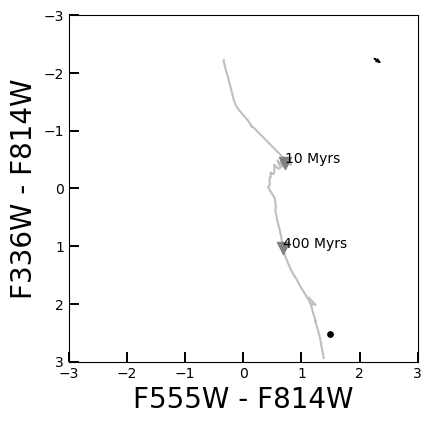

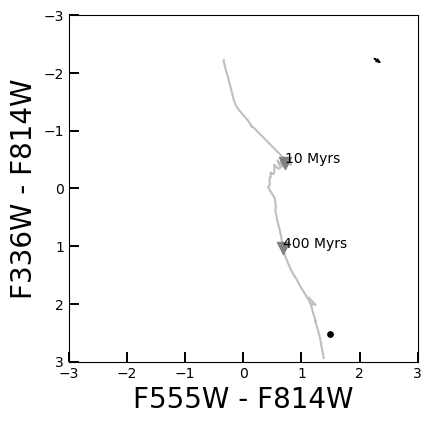

In [508]:
source = Find(clusters, 'Cluster ID == 46')
display(source)
print(source['Cluster Age (Myr)'].values)

# Coordinates: 11:20:15.83906851, +12:59:27.12463604
ext = 0.120 - 0.091 # B - V

MakeCCD(
    clusters=source,
    instrument='wfc3',
    xcolor=['F555W', 'F814W'],
    ycolor=['F336W', 'F814W'],
    E_BV=ext,
    correct_ext=True
)
MakeCCD(
    clusters=source.rename(columns={'F275W':'F225W', 'F275W Err':'F225W Err'}),
    instrument='wfc3',
    xcolor=['F555W', 'F814W'],
    ycolor=['F336W', 'F814W'],
    E_BV=ext,
    correct_ext=True
)

In [ ]:
# Z = 0.02
# stellar_lib = 'BaSeL'
# xorder = ['F555W', 'F814W']
# yorder = ['F438W', 'F555W']

isoTemp = Find(isoTemp, ["Z = " + str(Z), "Library = " + stellar_lib])
# filters = [filt for filt in source.columns.tolist() \
#            if len(filt) > 1 and filt[0] == "F" and 'Err' not in filt]
# vmag_filters = [filt for filt in isoTemp.columns.tolist() \
#            if len(filt) > 1  and filt[2] == "F" and filt[2:] in filters]

# expected = pd.DataFrame()
# for filt in vmag_filters:
#     temp_filter = filt[2:]
#     expected[temp_filter] = isoTemp['Vmag'] - isoTemp[filt] 

In [510]:
isoTemp['F438W - F555W'] = isoTemp['V-F555W'] - isoTemp['V-F438W']
isoTemp['F555W - F814W'] = isoTemp['V-F814W'] - isoTemp['V-F555W']
isoTemp['F336W - F555W'] = isoTemp['V-F555W'] - isoTemp['V-F336W']
isoTemp['F336W - F438W'] = isoTemp['V-F438W'] - isoTemp['V-F336W']

In [511]:
source['F438W - F555W'] = -(source['F438W'] - source['F555W'])
source['(F438W - F555W) Err'] = np.sqrt(source['F438W Err']**2 - source['F555W Err']**2)
source['F555W - F814W'] = -(source['F555W'] - source['F814W'])
source['(F555W - F814W) Err'] = np.sqrt(source['F555W Err']**2 - source['F814W Err']**2)
source['F336W - F555W'] = -(source['F336W'] - source['F555W'])
source['(F336W - F555W) Err'] = np.sqrt(source['F336W Err']**2 - source['F555W Err']**2)
source['F336W - F438W'] = -(source['F336W'] - source['F438W'])
source['(F336W - F438W) Err'] = np.sqrt(source['F336W Err']**2 - source['F438W Err']**2)

In [512]:
isoTemp['Test Statistic'] = np.nan

for index, row in isoTemp.iterrows():
    test_statistic = ((source['F438W - F555W'] - isoTemp['F438W - F555W'][index]) ** 2 / (source['(F438W - F555W) Err']) ** 2) \
                        + ((source['F555W - F814W'] - isoTemp['F555W - F814W'][index]) ** 2 / (source['(F555W - F814W) Err']) ** 2) \
                        + ((source['F336W - F555W'] - isoTemp['F336W - F555W'][index]) ** 2 / (source['(F336W - F555W) Err']) ** 2) \
                        + ((source['F336W - F438W'] - isoTemp['F336W - F438W'][index]) ** 2 / (source['(F336W - F438W) Err']) ** 2)
    isoTemp['Test Statistic'][index] = test_statistic

isoTemp.sort_values(by='Test Statistic')

,index,log-age-yr,Vmag,Kmag,V-F225W,V-F336W,V-F438W,V-F547M,V-F555W,V-F606W,V-F625W,V-F656N,V-F657N,V-F658N,V-F814W,log Nly,Mt/Lb,Mt/Lv,Mt/Lk,Z,Library,F438W - F555W,F555W - F814W,F336W - F555W,F336W - F438W,Test Statistic
41,41,6.459995,1.4070,2.1659,3.5478,2.3780,0.4490,-0.0018,0.0781,-0.0442,-0.1475,0.0309,-0.1338,-0.0945,-0.3599,46.7569,0.0155,0.0434,0.3507,0.0001,BaSeL,-0.3709,-0.4380,-2.2999,-1.9290,70129.538811
40,40,6.439995,1.5147,2.2715,3.5292,2.3627,0.4379,-0.0019,0.0753,-0.0418,-0.1406,0.0453,-0.1224,-0.0822,-0.3512,46.7850,0.0173,0.0481,0.3877,0.0001,BaSeL,-0.3626,-0.4265,-2.2874,-1.9248,71714.139411
39,39,6.420005,1.5527,2.3108,3.4865,2.3253,0.4191,-0.0019,0.0721,-0.0393,-0.1335,0.0603,-0.1103,-0.0691,-0.3403,46.7960,0.0183,0.0499,0.4032,0.0001,BaSeL,-0.3470,-0.4124,-2.2532,-1.9062,73677.514984
259,39,6.420005,1.3777,2.1280,3.5071,2.3407,0.4271,-0.0034,0.0745,-0.0367,-0.1302,0.0577,-0.1041,-0.0650,-0.3313,46.7131,0.0155,0.0425,0.3407,0.0004,BaSeL,-0.3526,-0.4058,-2.2662,-1.9136,74603.309780
258,38,6.400002,1.5126,2.2576,3.5248,2.3519,0.4303,-0.0035,0.0739,-0.0354,-0.1263,0.0604,-0.0993,-0.0607,-0.3289,46.7387,0.0175,0.0482,0.3850,0.0004,BaSeL,-0.3564,-0.4028,-2.2780,-1.9216,75028.305791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4559,159,9.698970,6.9555,2.9238,-3.2056,-1.4264,-1.0928,-0.0208,-0.1292,0.2734,0.5008,1.0432,0.8847,0.9334,1.5777,41.4696,5.5404,4.0729,0.3992,0.1000,stelib,0.9636,1.7069,1.2972,0.3336,677332.583623
4557,157,9.653213,6.8919,2.8421,-3.4307,-1.4154,-1.0954,-0.0206,-0.1296,0.2731,0.5000,1.0444,0.8855,0.9336,1.5868,41.5063,5.2587,3.8583,0.3719,0.1000,stelib,0.9658,1.7164,1.2858,0.3200,681382.729074
1461,141,9.255273,5.9187,1.3834,-3.8668,-1.2616,-0.9509,-0.0254,-0.1152,0.2518,0.4717,1.0029,0.8217,0.8623,1.6081,41.4036,2.0416,1.6679,0.1028,0.1000,BaSeL,0.8357,1.7233,1.1464,0.3107,683577.152715
4558,158,9.676694,6.9355,2.8776,-3.4329,-1.4349,-1.1031,-0.0206,-0.1302,0.2751,0.5033,1.0507,0.8909,0.9389,1.5942,41.4933,5.4956,4.0071,0.3834,0.1000,stelib,0.9729,1.7244,1.3047,0.3318,684851.101551


In [513]:
10 ** 9.278753 * u.yr.to(u.Myr)

1899.9973708862703

for each cluster:

$\text{test statistic} = (\frac{\text{cluster[F555W - F814W] - model[F555W - F814W]}}{\text{cluster[F555W Err - F814W Err]}}) ^ 2 + (\frac{\text{cluster[F438W - F555W] - model[F438W - F555W]}}{\text{cluster[438W Err - F555W Err]}}) ^ 2$


In [644]:
clusters.query('50>=`Cluster Age (Myr)`>=30')

,Cluster ID,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,PHANGS_F275W_mJy_TOT,PHANGS_F275W_mJy_TOT_ERR,PHANGS_F336W_mJy_TOT,PHANGS_F336W_mJy_TOT_ERR,PHANGS_F438W_mJy_TOT,PHANGS_F438W_mJy_TOT_ERR,PHANGS_F555W_mJy_TOT,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy_TOT,PHANGS_F814W_mJy_TOT_ERR,Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,NO_DETECTION_FLAG,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),RA,Dec
18,311,7185.47,3993.46,170.059692,12.947863,2.0,1.0,0.7,20.766444,0.026316,20.863658,0.023358,21.468270,0.014526,21.276444,0.008216,20.326735,0.009879,0.004376,0.000106,0.005523,0.000119,0.010659,0.000143,0.011296,0.000086,0.017840,0.000162,1.696675,37.0,30.0,45859.021427,30739.854010,0.25,0.17,0.428074,0.0,1.91,2.8268,0.113072,6.195079,170.059692,12.947863
39,741,7521.86,4686.74,170.055893,12.955493,1.0,1.0,0.7,22.451072,0.089768,21.943085,0.053257,22.454037,0.030797,21.893961,0.015933,20.474489,0.013489,0.000927,0.000077,0.002044,0.000100,0.004300,0.000122,0.006396,0.000094,0.015570,0.000194,1.544942,32.0,0.0,67578.587149,8599.442994,0.59,0.04,0.929888,0.0,0.59,0.8732,0.034928,1.913663,170.055893,12.955493
69,1400,6988.02,5441.98,170.061922,12.963805,2.0,2.0,1.0,20.082515,0.018858,20.093650,0.017990,20.607897,0.010742,20.355997,0.006949,19.349699,0.007547,0.008215,0.000143,0.011225,0.000186,0.023544,0.000233,0.026371,0.000169,0.043873,0.000305,1.692531,43.0,36.0,128642.161506,85679.095528,0.29,0.20,0.373671,0.0,1.32,1.9536,0.078144,4.281416,170.061922,12.963805
70,1429,6714.17,5464.61,170.065015,12.964054,1.0,1.0,0.9,21.676572,0.055622,21.866473,0.057554,22.264120,0.024950,22.100858,0.012803,21.123774,0.018028,0.001892,0.000097,0.002193,0.000116,0.005121,0.000118,0.005287,0.000062,0.008562,0.000142,1.505864,46.0,30.0,24159.843051,6172.868055,0.25,0.04,1.428071,0.0,0.77,1.1396,0.045584,2.497493,170.065015,12.964054
76,1640,6772.98,5632.10,170.064351,12.965897,2.0,2.0,1.0,21.542756,0.051801,21.728107,0.052995,22.445968,0.034838,22.424172,0.018432,21.685633,0.029617,0.002141,0.000102,0.002491,0.000122,0.004332,0.000139,0.003925,0.000067,0.005103,0.000139,1.629697,46.0,9.0,10793.032449,1507.007641,0.08,0.00,0.842806,0.0,1.18,1.7464,0.069856,3.827326,170.064351,12.965897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,10083,5277.44,9604.51,170.081244,13.009615,NaN,2.0,0.5,23.390664,0.211374,23.593766,0.218049,23.877566,0.085586,23.494205,0.056655,22.434741,0.051711,0.000390,0.000076,0.000447,0.000090,0.001159,0.000091,0.001465,0.000077,0.002560,0.000122,1.636871,46.0,25.0,8908.987422,886.840875,0.36,0.07,0.252769,0.0,1.32,1.9536,0.078144,4.281416,170.081244,13.009615
2605,10488,7282.12,10158.13,170.058600,13.015709,NaN,2.0,0.7,NaN,NaN,NaN,NaN,24.607736,0.167935,23.622935,0.067532,21.675530,0.032866,NaN,NaN,NaN,NaN,0.000591,0.000092,0.001301,0.000081,0.005151,0.000156,1.950981,37.0,2234.0,46155.550466,140628.907146,0.99,0.50,0.077756,2.0,5.00,7.4000,0.296000,16.217485,170.058600,13.015709
2638,10560,6055.70,10373.80,170.072453,13.018082,NaN,1.0,0.6,NaN,NaN,24.087766,0.322141,24.333932,0.115693,23.794039,0.068892,22.433211,0.058759,NaN,NaN,0.000283,0.000084,0.000761,0.000081,0.001111,0.000071,0.002563,0.000139,1.497832,43.0,139.0,11964.491441,11551.791329,0.56,0.07,0.029074,1.0,0.77,1.1396,0.045584,2.497493,170.072453,13.018082
2647,10570,6250.90,10423.72,170.070248,13.018632,NaN,2.0,0.9,23.782128,0.294440,24.131655,0.312179,24.140542,0.105636,23.801446,0.074950,22.450539,0.057566,0.000272,0.000074,0.000272,0.000078,0.000910,0.000089,0.001104,0.000076,0.002523,0.000134,1.781201,34.0,84.0,9704.071481,959

## A different approach

In [645]:
isoTemp = remove_unnamed(pd.read_csv('/Users/undergradstudent/Downloads/CB07_models_wfc3_uvis.csv'))
# isoTemp = Find(isoTemp, ['Z = 0.02', 'Library = BaSeL'])
isoTemp = Find(isoTemp, ['Library = BaSeL'])
# src = Find(clusters, 'Cluster ID == 285')
# src = Find(clusters, 'Cluster ID == 8629')
# src = Find(clusters, 'Cluster ID == 46')
src = Find(clusters, 'Cluster ID == 1429')
display(src)
display(isoTemp)

,Cluster ID,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,PHANGS_F275W_mJy_TOT,PHANGS_F275W_mJy_TOT_ERR,PHANGS_F336W_mJy_TOT,PHANGS_F336W_mJy_TOT_ERR,PHANGS_F438W_mJy_TOT,PHANGS_F438W_mJy_TOT_ERR,PHANGS_F555W_mJy_TOT,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy_TOT,PHANGS_F814W_mJy_TOT_ERR,Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,NO_DETECTION_FLAG,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),RA,Dec
0,1429,6714.17,5464.61,170.065015,12.964054,1.0,1.0,0.9,21.676572,0.055622,21.866473,0.057554,22.26412,0.02495,22.100858,0.012803,21.123774,0.018028,0.001892,0.000097,0.002193,0.000116,0.005121,0.000118,0.005287,0.000062,0.008562,0.000142,1.505864,46.0,30.0,24159.843051,6172.868055,0.25,0.04,1.428071,0.0,0.77,1.1396,0.045584,2.497493,170.065015,12.964054


,level_0,log-age-yr,Vmag,Kmag,V-F225W,V-F336W,V-F438W,V-F547M,V-F555W,V-F606W,V-F625W,V-F656N,V-F657N,V-F658N,V-F814W,log Nly,Mt/Lb,Mt/Lv,Mt/Lk,Z,Library
0,0,5.000000,1.8560,2.6119,3.2444,2.1235,0.3324,-0.0021,0.0603,-0.0299,-0.1082,0.1078,-0.0684,-0.0252,-0.2956,46.6960,0.0264,0.0664,0.5355,0.0001,BaSeL
1,1,5.149989,1.8560,2.6119,3.2444,2.1235,0.3324,-0.0021,0.0603,-0.0299,-0.1082,0.1078,-0.0684,-0.0252,-0.2956,46.6960,0.0264,0.0664,0.5355,0.0001,BaSeL
2,2,5.200002,1.8560,2.6119,3.2444,2.1235,0.3324,-0.0021,0.0603,-0.0299,-0.1082,0.1078,-0.0684,-0.0252,-0.2956,46.6960,0.0264,0.0664,0.5355,0.0001,BaSeL
3,3,5.250005,1.8560,2.6119,3.2444,2.1235,0.3324,-0.0021,0.0603,-0.0299,-0.1082,0.1078,-0.0684,-0.0252,-0.2956,46.6960,0.0264,0.0664,0.5355,0.0001,BaSeL
4,4,5.300008,1.8560,2.6119,3.2444,2.1235,0.3324,-0.0021,0.0603,-0.0299,-0.1082,0.1078,-0.0684,-0.0252,-0.2956,46.6960,0.0264,0.0664,0.5355,0.0001,BaSeL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,1535,10.278753,8.1472,4.1781,0.1763,-0.2472,-0.6601,-0.0221,-0.0854,0.2166,0.4129,0.8880,0.7091,0.7566,1.2840,41.0551,11.0139,11.5400,1.1983,0.1000,BaSeL
1536,1536,10.284431,8.1580,4.1860,0.2027,-0.2284,-0.6547,-0.0221,-0.0849,0.2160,0.4118,0.8865,0.7077,0.7551,1.2829,41.0600,11.0667,11.6486,1.2064,0.1000,BaSeL
1537,1537,10.290034,8.1689,4.1940,0.2276,-0.2105,-0.6496,-0.0220,-0.0844,0.2155,0.4107,0.8851,0.7063,0.7537,1.2820,41.0647,11.1237,11.7602,1.2146,0.1000,BaSeL
1538,1538,10.295568,8.1801,4.2019,0.2513,-0.1934,-0.6446,-0.0220,-0.0839,0.2149,0.4097,0.8838,0.7050,0.7524,1.2812,41.0690,11.1856,11.8762,1.2229,0.1000,BaSeL


In [646]:
# Calculate colours with the clusters and the model photometry
src['V - I'] = src['F555W'] - src['F814W']
src['B - V'] = src['F438W'] - src['F555W']
src['B - I'] = src['F438W'] - src['F814W']
src['UV - B'] = src['F336W'] - src['F438W']
src['V - I Err'] = np.sqrt(src['F555W Err']**2 + src['F814W Err']**2)
src['B - V Err'] = np.sqrt(src['F438W Err']**2 + src['F555W Err']**2)
src['B - I Err'] = np.sqrt(src['F438W Err']**2 + src['F814W Err']**2)
src['UV - B Err'] = np.sqrt(src['F336W Err']**2 + src['F438W Err']**2)

isoTemp['V - I'] = isoTemp['V-F814W'] - isoTemp['V-F555W']
isoTemp['B - V'] = isoTemp['V-F555W'] - isoTemp['V-F438W']
isoTemp['B - I'] = isoTemp['V-F814W'] - isoTemp['V-F438W']
isoTemp['UV - B'] = isoTemp['V-F438W'] - isoTemp['V-F336W']

In [647]:
# Find the test statistic with each model measurement
isoTemp['Test Statistic'] = np.nan
for index, row in isoTemp.iterrows():
    test_statistic = (src['V - I'] - isoTemp['V - I'][index]) ** 2 / src['V - I Err'] ** 2 + \
                     (src['B - V'] - isoTemp['B - V'][index]) ** 2 / src['B - V Err'] ** 2 + \
                     (src['B - I'] - isoTemp['B - I'][index]) ** 2 / src['B - I Err'] ** 2 + \
                     (src['UV - B'] - isoTemp['UV - B'][index]) ** 2 / src['UV - B Err'] ** 2
    isoTemp['Test Statistic'][index] = test_statistic


isoMatches = isoTemp.sort_values(by='Test Statistic').reset_index(drop=True)
isoMatches

,level_0,log-age-yr,Vmag,Kmag,V-F225W,V-F336W,V-F438W,V-F547M,V-F555W,V-F606W,V-F625W,V-F656N,V-F657N,V-F658N,V-F814W,log Nly,Mt/Lb,Mt/Lv,Mt/Lk,Z,Library,V - I,B - V,B - I,UV - B,Test Statistic
0,1442,8.406540,4.0244,0.2804,-0.6175,-0.2353,-0.2029,-0.0089,-0.0289,0.0898,0.1745,0.4339,0.3444,0.3618,0.8839,41.1101,0.2145,0.3262,0.0417,0.1000,BaSeL,0.9128,0.1740,1.0868,0.0324,58.623204
1,1443,8.456549,4.1082,0.3450,-0.7584,-0.2965,-0.2325,-0.0095,-0.0327,0.0961,0.1873,0.4544,0.3628,0.3813,0.9028,41.0711,0.2361,0.3497,0.0439,0.1000,BaSeL,0.9355,0.1998,1.1353,0.0640,59.420730
2,1441,8.356543,3.9430,0.2158,-0.4851,-0.1725,-0.1738,-0.0081,-0.0251,0.0829,0.1604,0.4112,0.3240,0.3402,0.8657,41.1417,0.1953,0.3049,0.0396,0.1000,BaSeL,0.8908,0.1487,1.0395,-0.0013,66.150899
3,1444,8.506546,4.1937,0.4358,-0.9222,-0.3630,-0.2667,-0.0103,-0.0371,0.1035,0.2022,0.4800,0.3852,0.4046,0.9315,41.0321,0.2614,0.3754,0.0474,0.1000,BaSeL,0.9686,0.2296,1.1982,0.0963,71.279108
4,338,8.206556,2.9993,0.4944,0.7163,0.3482,-0.1307,-0.0130,-0.0265,0.1031,0.1910,0.4492,0.3434,0.3763,0.8266,40.9898,0.0861,0.1419,0.0568,0.0004,BaSeL,0.8531,0.1042,0.9573,-0.4789,72.914553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,258,6.400002,1.5126,2.2576,3.5248,2.3519,0.4303,-0.0035,0.0739,-0.0354,-0.1263,0.0604,-0.0993,-0.0607,-0.3289,46.7387,0.0175,0.0482,0.3850,0.0004,BaSeL,-0.4028,-0.3564,-0.7592,-1.9216,8635.979836
1536,259,6.420005,1.3777,2.1280,3.5071,2.3407,0.4271,-0.0034,0.0745,-0.0367,-0.1302,0.0577,-0.1041,-0.0650,-0.3313,46.7131,0.0155,0.0425,0.3407,0.0004,BaSeL,-0.4058,-0.3526,-0.7584,-1.9136,8638.540170
1537,39,6.420005,1.5527,2.3108,3.4865,2.3253,0.4191,-0.0019,0.0721,-0.0393,-0.1335,0.0603,-0.1103,-0.0691,-0.3403,46.7960,0.0183,0.0499,0.4032,0.0001,BaSeL,-0.4124,-0.3470,-0.7594,-1.9062,8666.976701
1538,40,6.439995,1.5147,2.2715,3.5292,2.3627,0.4379,-0.0019,0.0753,-0.0418,-0.1406,0.0453,-0.1224,-0.0822,-0.3512,46.7850,0.0173,0.0481,0.3877,0.0001,BaSeL,-0.4265,-0.3626,-0.7891,-1.9248,8902.451107


In [648]:
print(f'Cluster age: {src['Cluster Age (Myr)'][0]} +- {src['Cluster Age Err (Myr)'][0]}')
print(f'Model Age : {10 ** isoMatches['log-age-yr'][0] * u.yr.to(u.Myr)}')

Cluster age: 46.0 +- 30.0
Model Age : 254.99989405656527


Cluster age: 46.0 +- 30.0
Model Age : 254.99989405656527
Plotting reddening arrow for V-I vs. B-V
Plotting reddening arrow for V-I vs. B-V


<module 'matplotlib.pyplot' from '/Users/undergradstudent/anaconda3/envs/stenv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

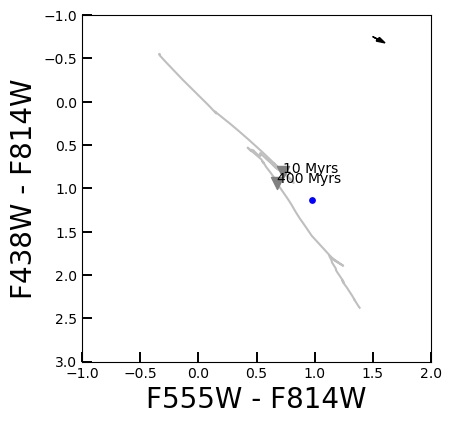

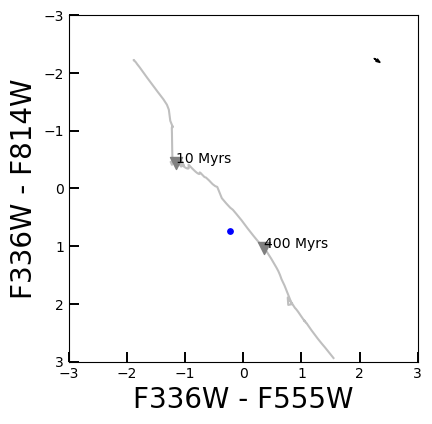

In [650]:
print(f'Cluster age: {src['Cluster Age (Myr)'][0]} +- {src['Cluster Age Err (Myr)'][0]}')
print(f'Model Age : {10 ** isoMatches['log-age-yr'][0] * u.yr.to(u.Myr)}')
MakeCCD(src, color="blue", E_BV=ext, correct_ext=False,
xcolor=['F555W', 'F814W'], ycolor=['F438W', 'F814W'],
instrument='wfc3', label_ages=True, xlim=(-1, 2), ylim=(3, -1))

MakeCCD(src, color="blue", E_BV=ext, correct_ext=False,
        xcolor=['F336W', 'F555W'], ycolor=['F336W', 'F814W'],
        instrument='wfc3', label_ages=True)


In [641]:
# MakeCCD(
#     clusters=source,
#     instrument='wfc3',
#     xcolor=['F336W', 'F438W'],
#     ycolor=['F438W', 'F555W'],
#     E_BV=ext,
#     correct_ext=False
# )
# MakeCCD(
#     clusters=source,
#     instrument='wfc3',
#     xcolor=['F336W', 'F438W'],
#     ycolor=['F555W', 'F814W'],
#     E_BV=ext,
#     correct_ext=False
# )